In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from models import TrajectoryGraph, initialize_trajectory


In [2]:
adata = sc.read('/home/kamdar.jh/viCSHMM/panc_endoc_mouse.h5ad')

/home/kamdar.jh/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs_names_make_unique()

In [4]:
# === REPLACE cell_type using mapping file ===
mapping_df = pd.read_csv("cell_id_to_cell_type.csv").drop_duplicates(subset="cell_id")
cell_type_dict = mapping_df.set_index("cell_id")["cell_type"].to_dict()
adata.obs['cell_type'] = adata.obs.index.map(cell_type_dict)
adata = adata[~adata.obs['cell_type'].isna()].copy()  # Drop unmapped cells

# === Merge similar labels ===
adata.obs['cell_type'] = adata.obs['cell_type'].replace({
    'Ngn3+ EP': 'Endocrine Progenitor',
    'Ngn3- EP': 'Endocrine Progenitor',
    'Endocrine': 'Endocrine Progenitor'
})

# === Convert to category ===
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

/home/kamdar.jh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/kamdar.jh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


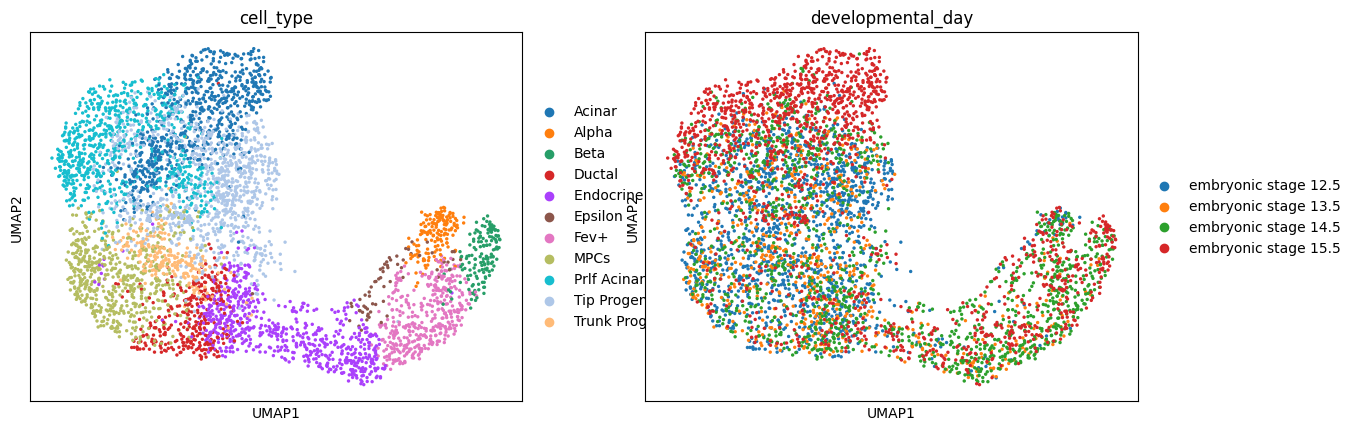

In [5]:
sc.pl.umap(adata, color = ['cell_type', 'developmental_day'])

In [6]:
# import cellrank as cr
# adata = cr.datasets.reprogramming_schiebinger(subset_to_serum=True)
# sc.pp.subsample(adata, fraction=.30135, random_state=0)
# adata

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes = 1000, batch_key = 'developmental_day', subset=True)

In [8]:
# adata.obs['cell_type'] = adata.obs['cell_type'].replace({
#     'Ngn3+ EP': 'Endocrine Progenitor',
#     'Ngn3- EP': 'Endocrine Progenitor'
# })


In [9]:
# import pandas as pd

# # Assumes 'cell_type' is in adata.obs
# df = adata.obs[['cell_type']]
# df.index.name = 'cell_id'
# df.to_csv('cell_id_to_cell_type.csv')


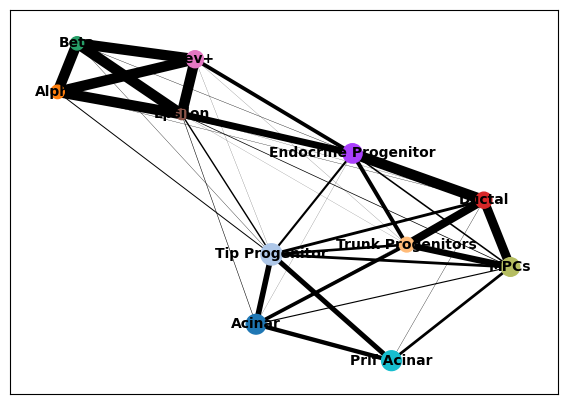

In [10]:
sc.tl.paga(adata, groups = 'cell_type', )
sc.pl.paga(adata) 

In [11]:
label_color_map = {
    'MPCs': '#E69F00',               # orange
    'Tip Progenitor': '#56B4E9',     # sky blue
    'Trunk Progenitors': '#009E73',  # green
    'Prlf Acinar': '#F0E442',        # yellow
    'Acinar': '#0072B2',             # blue
    'Ductal': '#D55E00',             # vermillion
    'Endocrine Progenitor': '#CC79A7', # purple
    'Fev+': '#999999',               # gray
    'Epsilon': '#A6761D',            # brown
    'Alpha': '#1B9E77',              # teal green
    'Beta': '#E41A1C'                # red
}


/home/kamdar.jh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


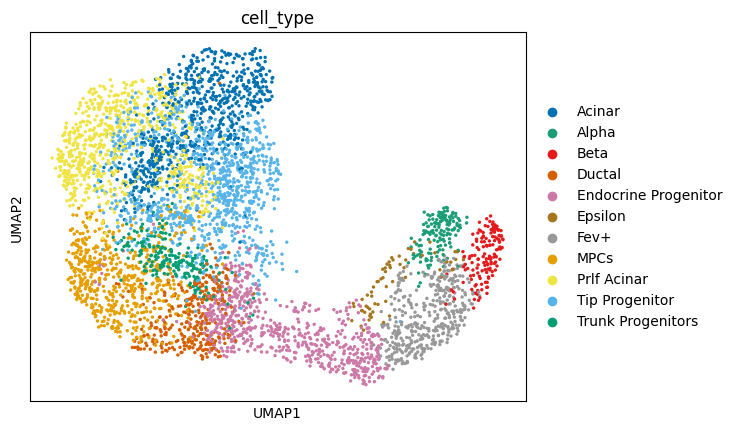

<Axes: >

In [12]:
import scanpy as sc

# Define colorblind-friendly color map
label_color_map = {
    'MPCs': '#E69F00',
    'Tip Progenitor': '#56B4E9',
    'Trunk Progenitors': '#009E73',
    'Prlf Acinar': '#F0E442',
    'Acinar': '#0072B2',
    'Ductal': '#D55E00',
    'Endocrine Progenitor': '#CC79A7',
    'Fev+': '#999999',
    'Epsilon': '#A6761D',
    'Alpha': '#1B9E77',
    'Beta': '#E41A1C'
}

# Apply color map
adata.uns['cell_type_colors'] = [label_color_map[ct] for ct in adata.obs['cell_type'].cat.categories]

# Save UMAP plot
sc.pl.umap(
    adata,
    color='cell_type',
    save='_cell_type.pdf'
)

# Save PAGA plot without labels
sc.pl.paga(
    adata,
    labels=None,
    show=False,
    save='_paga.pdf'
)


In [13]:
adata.obs_names_make_unique()

In [14]:
adata.X

<4978x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 943809 stored elements in Compressed Sparse Row format>

In [15]:
from models import EMTrainer, TrajectoryGraph, initialize_trajectory


In [16]:
#Panc DEV

topology_config = [
    ('MPCs', 'Tip Progenitor'),
    ('MPCs', 'Trunk Progenitors'),
    ('Trunk Progenitors', 'Ductal'),
    ('Trunk Progenitors', 'Endocrine Progenitor'),
    ('Endocrine Progenitor', 'Fev+'),
    ('Endocrine Progenitor', 'Epsilon'),
    ('Fev+', 'Alpha'),
    ('Fev+', 'Beta'),
    ('Tip Progenitor', 'Prlf Acinar'),
    ('Tip Progenitor', 'Acinar')
]

# topology_config = [
#     ('IPS', 'MET'),
#     ('IPS', 'MEF/other'),
#     ('MEF/other', 'Stromal'),
#     ('MET', 'Epithelial'),
#     ('MET', 'Neural'),
#     ('Epithelial', 'Trophoblast')
# ]

Trajectory graph nodes: ['leaf__CL__Acinar', 'leaf__CL__Alpha', 'leaf__CL__Beta', 'leaf__CL__Ductal', 'split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon', 'split__CL__Fev+', 'root_split__CL__MPCs', 'leaf__CL__Prlf Acinar', 'split__CL__Tip Progenitor', 'split__CL__Trunk Progenitors', 'RootNode_0']
Trajectory graph edges: [('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon'), ('split__CL__Endocrine Progenitor', 'split__CL__Fev+'), ('split__CL__Fev+', 'leaf__CL__Alpha'), ('split__CL__Fev+', 'leaf__CL__Beta'), ('root_split__CL__MPCs', 'split__CL__Tip Progenitor'), ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors'), ('split__CL__Tip Progenitor', 'leaf__CL__Acinar'), ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar'), ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal'), ('split__CL__Trunk Progenitors', 'split__CL__Endocrine Progenitor'), ('RootNode_0', 'root_split__CL__MPCs')]
Initial Global r2 (sample): [0.07269863 0.03641438 0.01250116 0.00462042 0.05364793]
Initial Trans

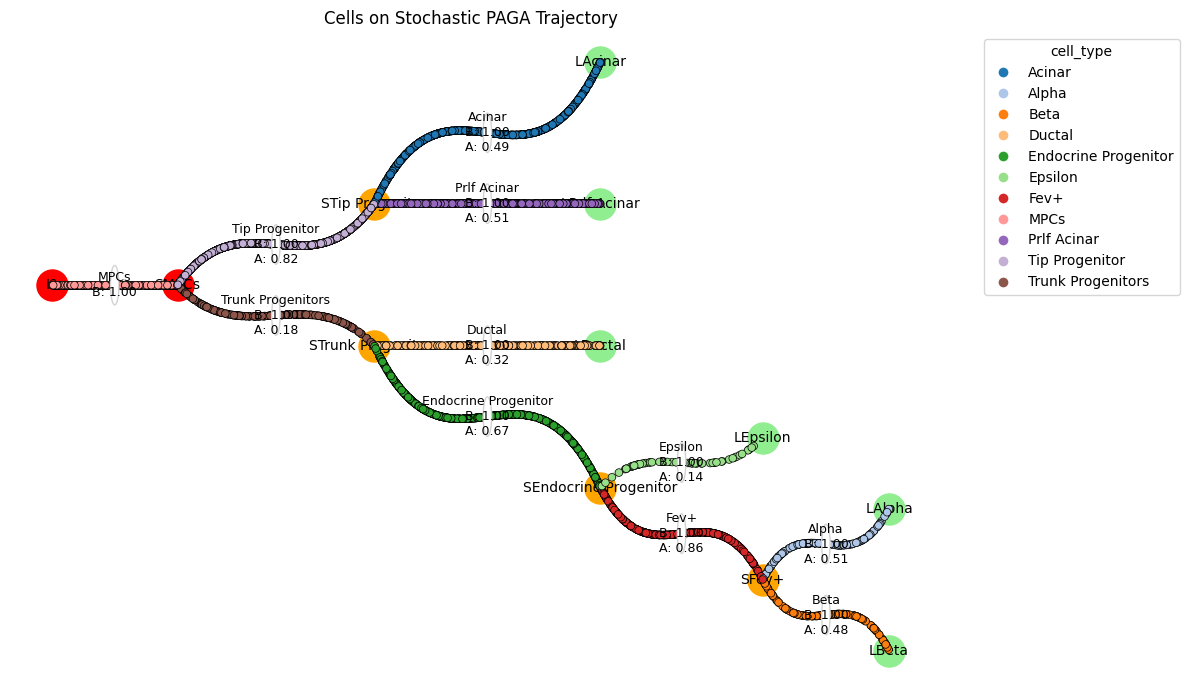

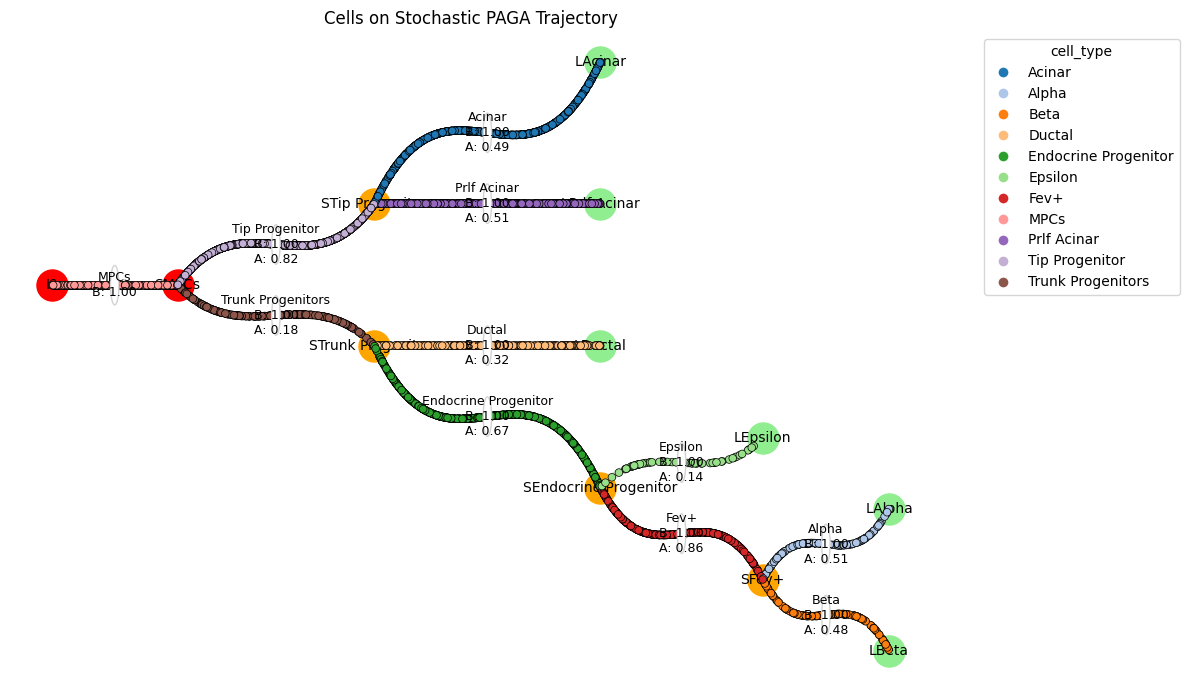

In [17]:
# Build the trajectory graph
traj_graph, cell_assignment = initialize_trajectory(
    adata=adata,
    random_state=1,
    cluster_key = 'cell_type',
    topology_config = topology_config,
    debug=True
)

# Visualize trajectory graph with cells assigned
traj_graph.plot_cells_on_trajectory(
    cell_assignment=cell_assignment,
    color_key='cell_type',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Cells on Stochastic PAGA Trajectory",
    plot_transitions=True
)


🧠 Saving expression matrix to shared memory...
🧠 Saving expression matrix to shared memory...

📈 Initializing K from g_a, g_b deltas...

🌀 EM ITERATION 1/10
---------M Step 0---------

🧠 Optimizing K parameters (PyTorch)...


/home/kamdar.jh/tsCSHMM/models/em_trainer.py:478: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788959220/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  X = torch.from_numpy(self._load_shared_X()).to(dtype=torch.float32, device=self.device)


✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.0650 | Last NLL: 2324.985107
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.8371 | Last NLL: 988.977478
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.8786 | Last NLL: 887.203735
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.3311 | Last NLL: 844.258240
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7749 | Last NLL: -159.673355
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2678 | Last NLL: -163.487976
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9698 | Last NLL: -273.014008
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3856 | Last NLL: -306.455994
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2.9290 | Last NLL: -130.056976
✅ Edge ('split__CL__Trunk Progenitors', 'split__CL__Endocri

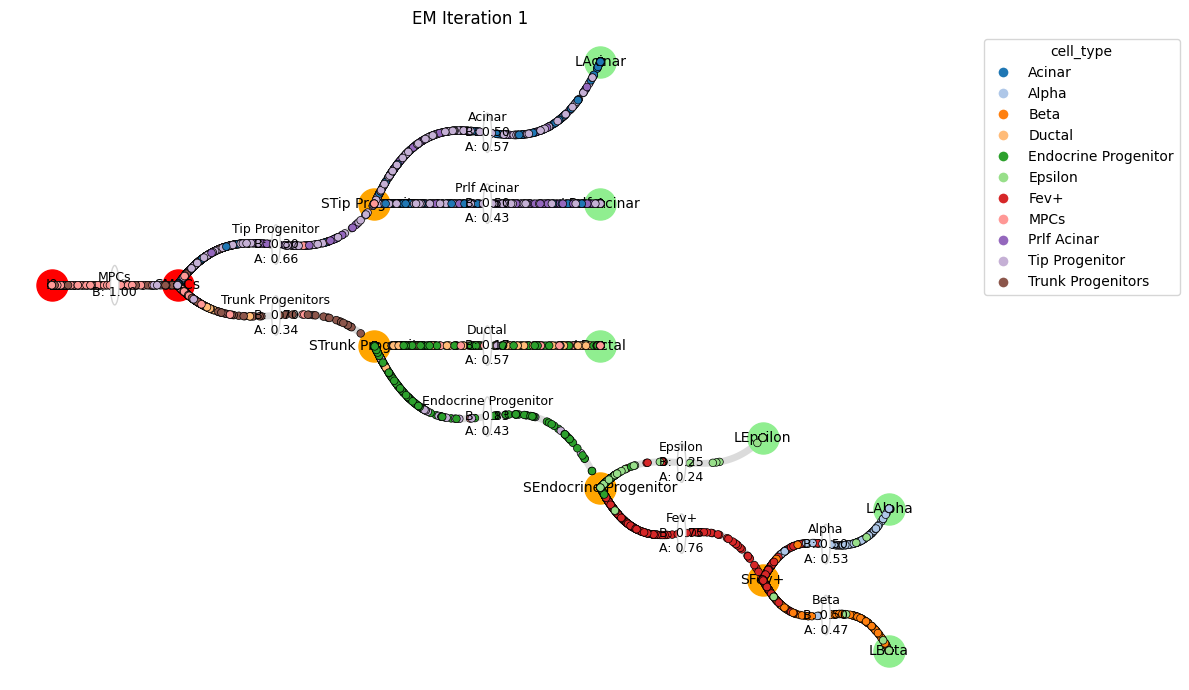


🌀 EM ITERATION 2/10
---------M Step 1---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.0647 | Last NLL: 1444.335815
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.8361 | Last NLL: 791.491699
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.8876 | Last NLL: 952.129883
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.3424 | Last NLL: 851.658142
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7758 | Last NLL: -245.849838
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2678 | Last NLL: -183.350067
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9728 | Last NLL: -289.885254
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3857 | Last NLL: -316.546021
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2.

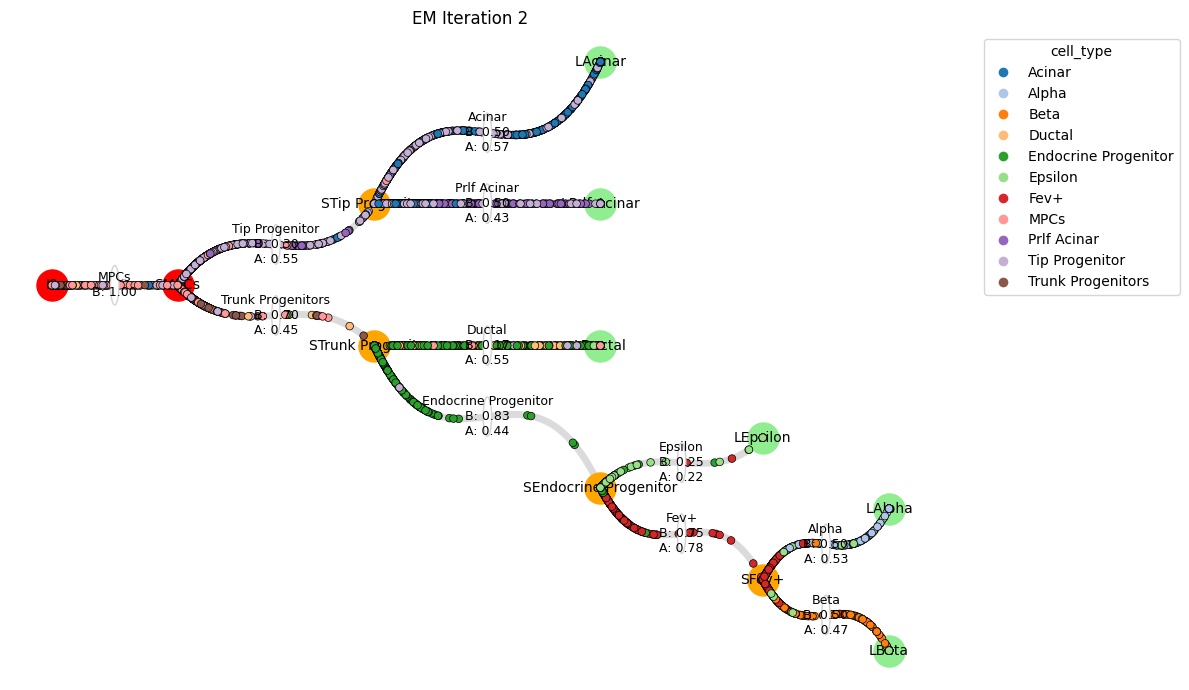


🌀 EM ITERATION 3/10
---------M Step 2---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.0741 | Last NLL: 1426.894775
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.8524 | Last NLL: 725.680542
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.8987 | Last NLL: 995.685364
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.3599 | Last NLL: 903.187866
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7772 | Last NLL: -284.421570
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2691 | Last NLL: -219.687729
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9777 | Last NLL: -325.799225
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3875 | Last NLL: -343.744659
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2.

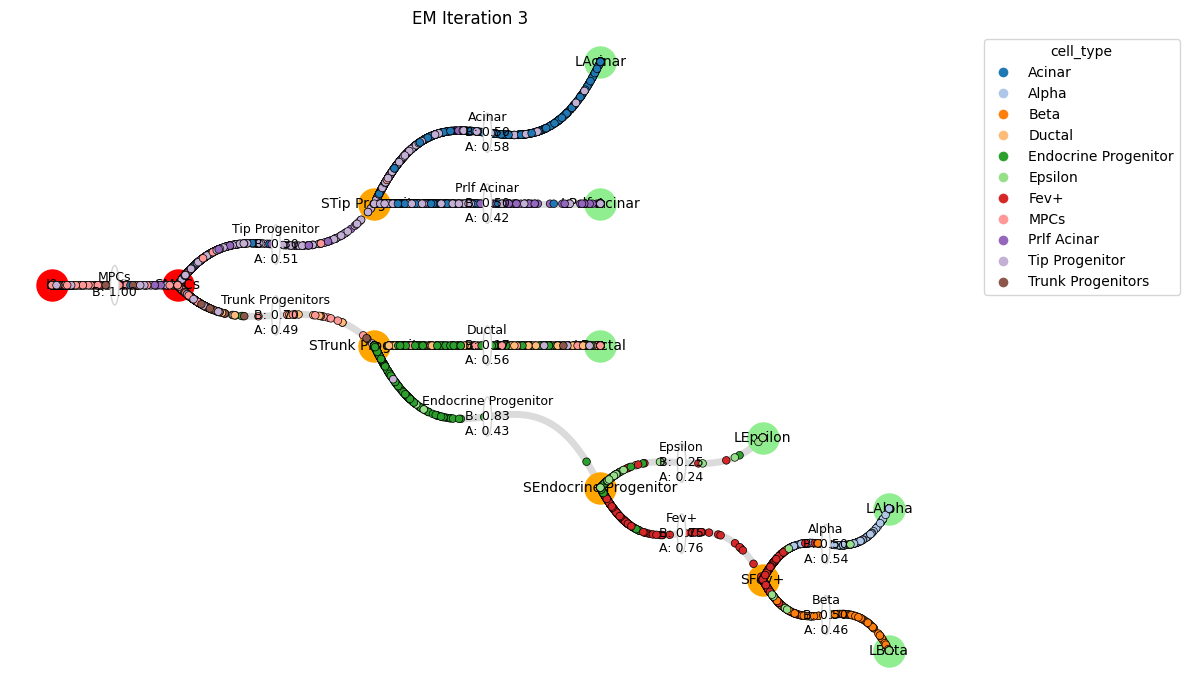


🌀 EM ITERATION 4/10
---------M Step 3---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.0860 | Last NLL: 1390.614990
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.8710 | Last NLL: 722.842407
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.9087 | Last NLL: 1015.067444
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.3772 | Last NLL: 919.039062
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7784 | Last NLL: -300.736603
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2708 | Last NLL: -227.622910
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9833 | Last NLL: -330.338959
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3895 | Last NLL: -356.024139
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2

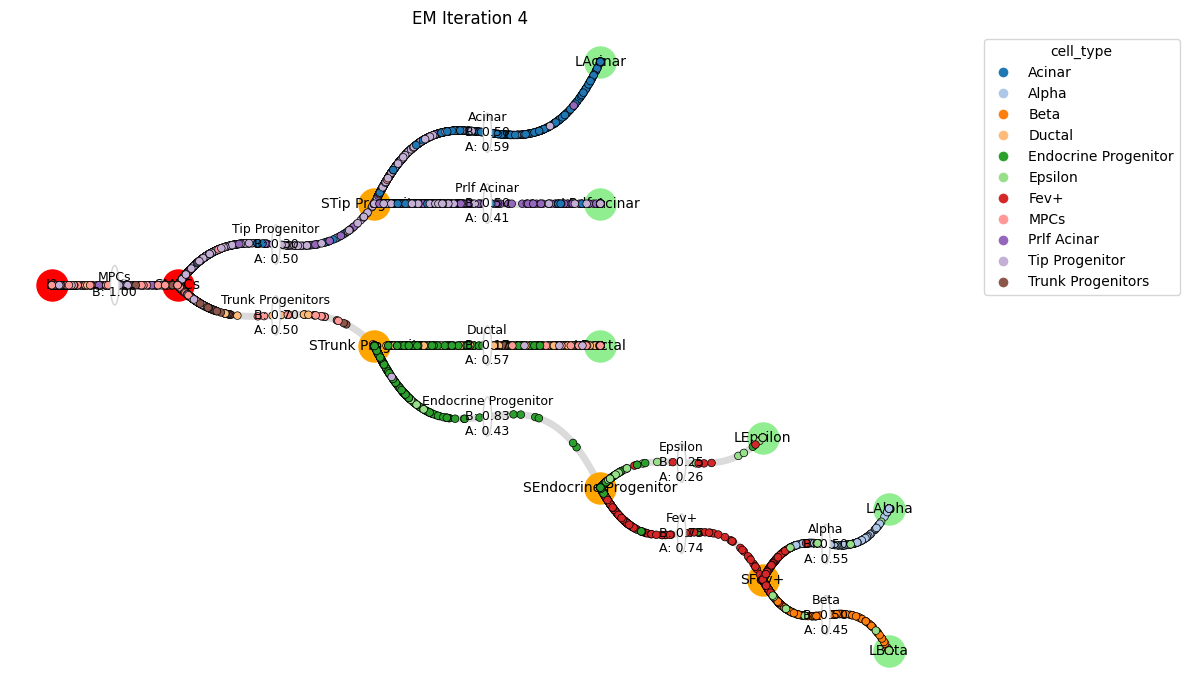


🌀 EM ITERATION 5/10
---------M Step 4---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.0974 | Last NLL: 1368.645996
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.8895 | Last NLL: 730.061218
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.9187 | Last NLL: 1013.830627
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.3936 | Last NLL: 919.899719
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7800 | Last NLL: -303.234528
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2726 | Last NLL: -228.916702
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9881 | Last NLL: -331.078400
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3913 | Last NLL: -359.407440
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2

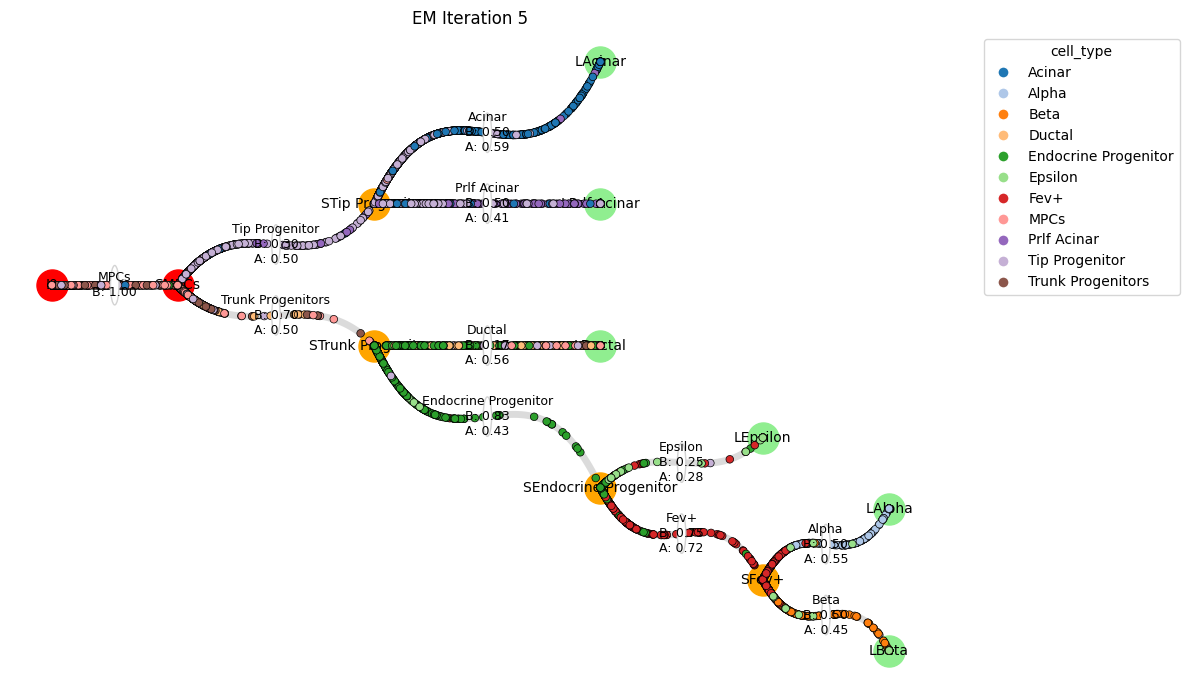


🌀 EM ITERATION 6/10
---------M Step 5---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.1086 | Last NLL: 1344.030029
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.9069 | Last NLL: 755.434937
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.9283 | Last NLL: 1011.928284
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.4097 | Last NLL: 917.180237
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7814 | Last NLL: -303.285736
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2740 | Last NLL: -230.274490
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9921 | Last NLL: -332.407135
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3931 | Last NLL: -360.890472
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2

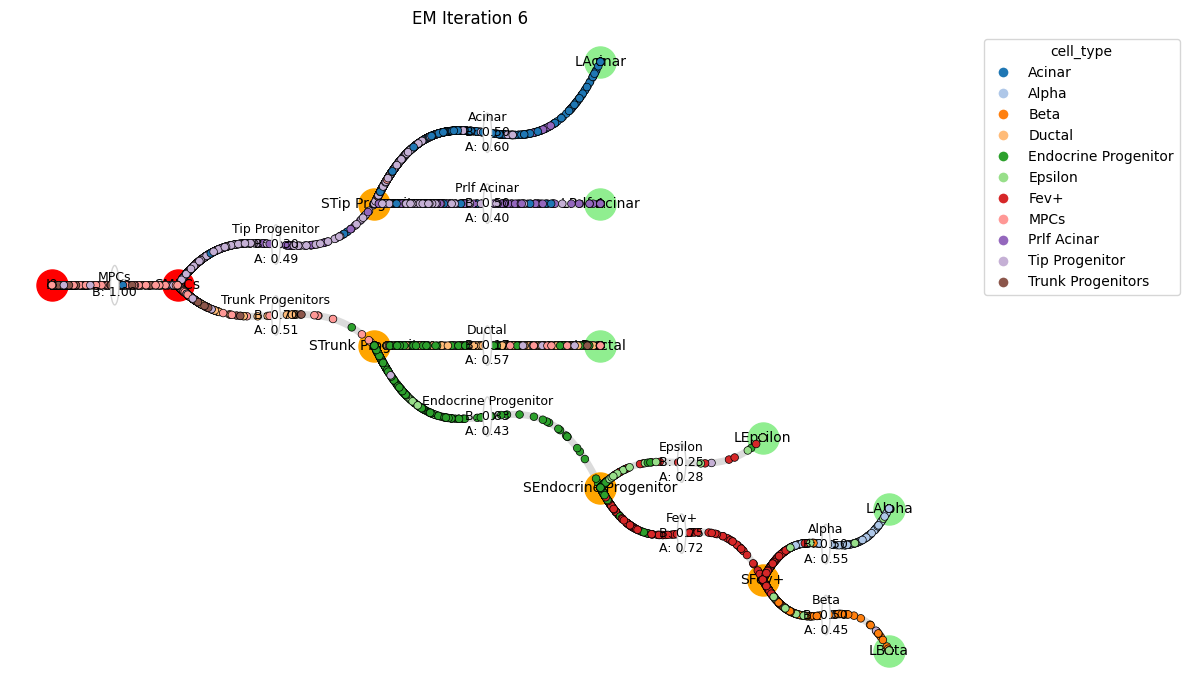


🌀 EM ITERATION 7/10
---------M Step 6---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.1205 | Last NLL: 1332.654907
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.9223 | Last NLL: 755.672791
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.9378 | Last NLL: 1014.291626
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.4272 | Last NLL: 919.217041
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7829 | Last NLL: -306.056641
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2752 | Last NLL: -227.771881
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9956 | Last NLL: -333.234924
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3946 | Last NLL: -362.308075
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2

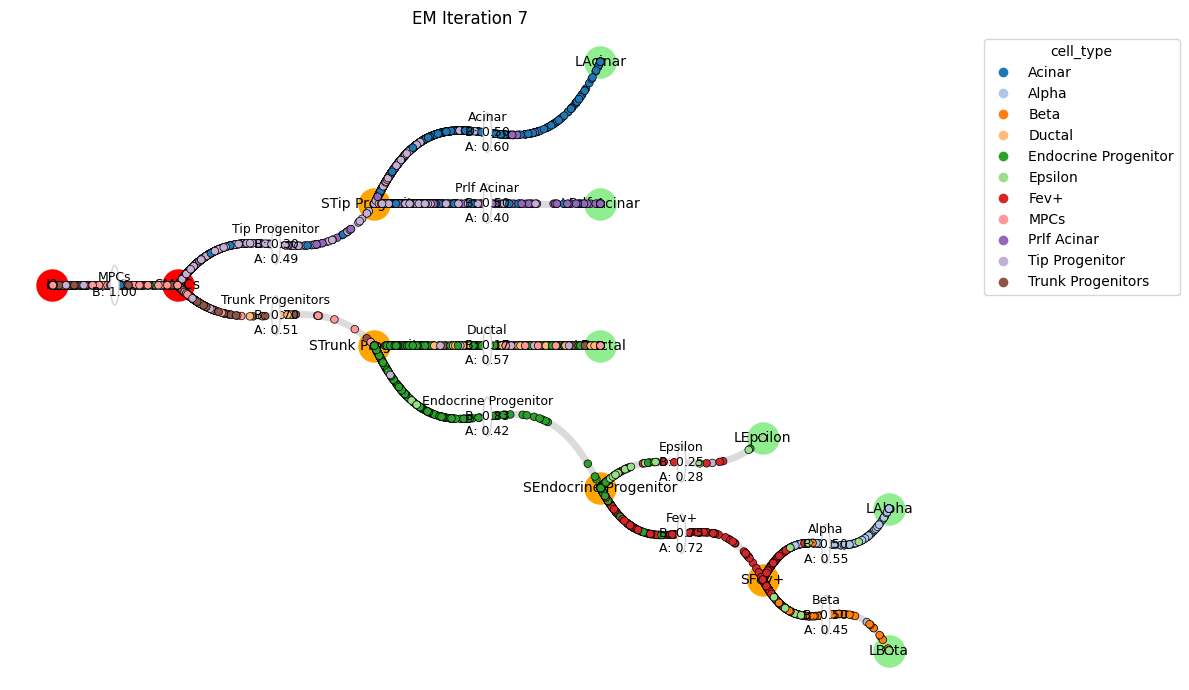


🌀 EM ITERATION 8/10
---------M Step 7---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.1316 | Last NLL: 1315.314453
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.9359 | Last NLL: 768.857910
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.9476 | Last NLL: 1013.838013
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.4452 | Last NLL: 921.120239
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7843 | Last NLL: -306.505768
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2764 | Last NLL: -228.132111
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 1.9987 | Last NLL: -334.432281
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3961 | Last NLL: -363.363586
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2

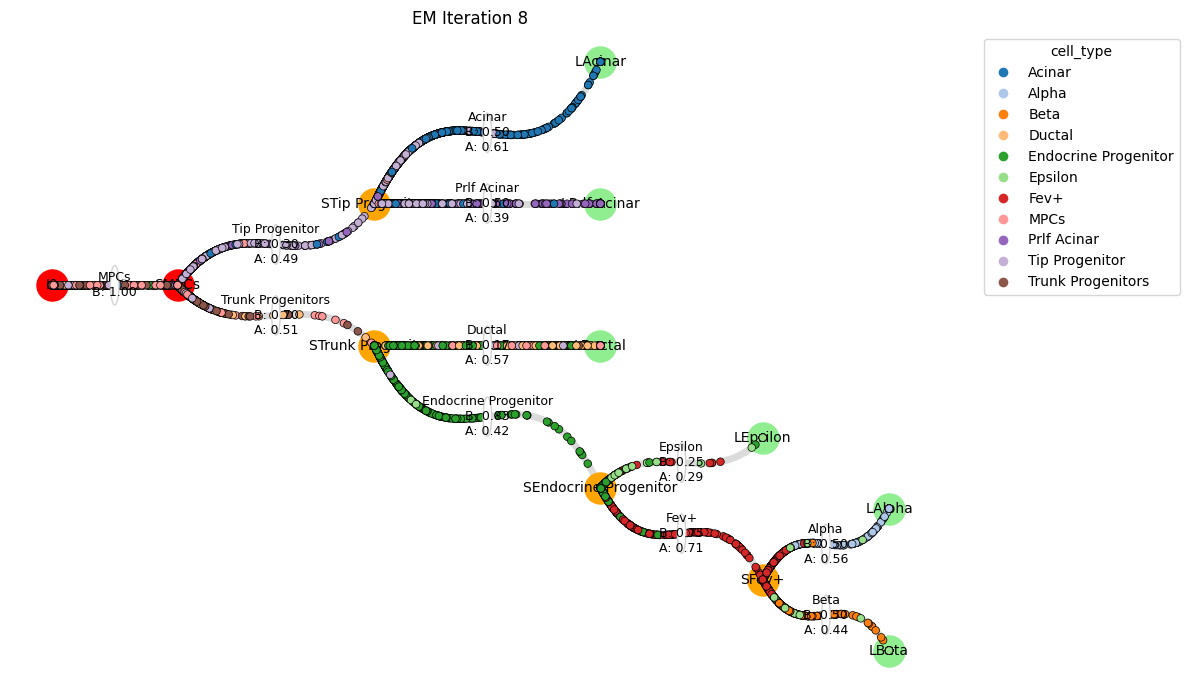


🌀 EM ITERATION 9/10
---------M Step 8---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.1420 | Last NLL: 1275.636719
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.9470 | Last NLL: 779.958862
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.9577 | Last NLL: 1013.533936
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.4628 | Last NLL: 920.928528
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7856 | Last NLL: -307.143280
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2776 | Last NLL: -227.869202
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 2.0014 | Last NLL: -335.399292
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3976 | Last NLL: -362.925323
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 2

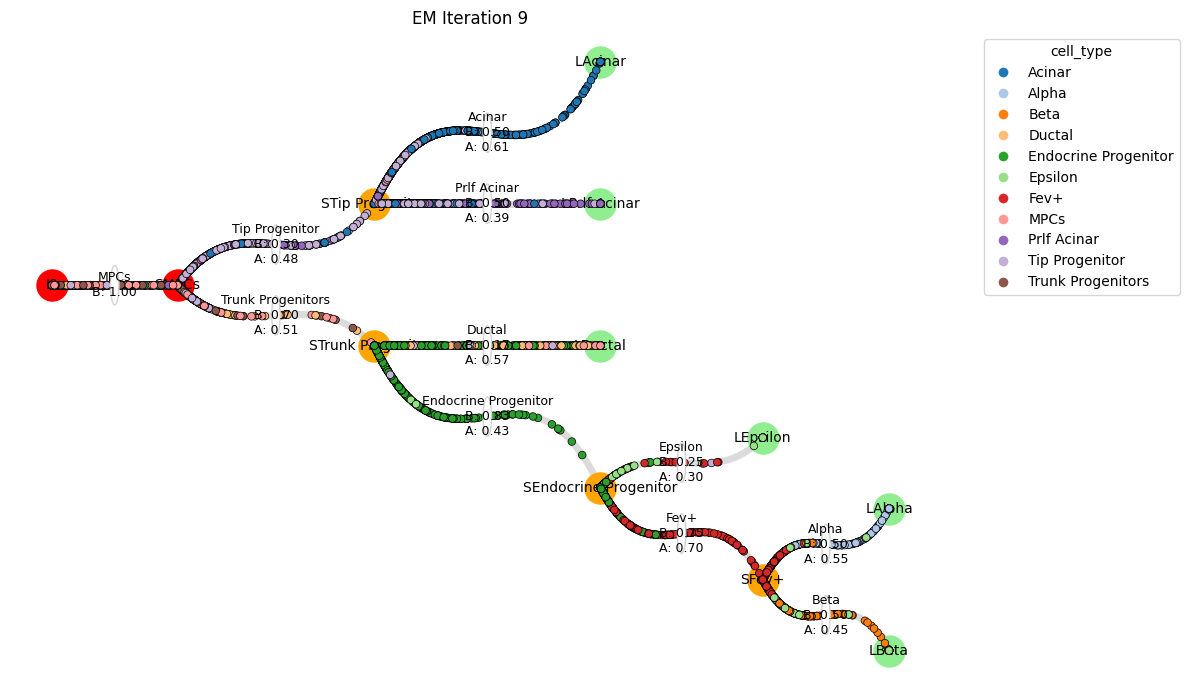


🌀 EM ITERATION 10/10
---------M Step 9---------

🧠 Optimizing K parameters (PyTorch)...
✅ Edge ('split__CL__Endocrine Progenitor', 'leaf__CL__Epsilon') | Final K mean: 4.1514 | Last NLL: 1255.381348
✅ Edge ('split__CL__Endocrine Progenitor', 'split__CL__Fev+') | Final K mean: 4.9562 | Last NLL: 778.232971
✅ Edge ('split__CL__Fev+', 'leaf__CL__Alpha') | Final K mean: 3.9682 | Last NLL: 1014.574890
✅ Edge ('split__CL__Fev+', 'leaf__CL__Beta') | Final K mean: 3.4793 | Last NLL: 920.842102
✅ Edge ('root_split__CL__MPCs', 'split__CL__Tip Progenitor') | Final K mean: 2.7867 | Last NLL: -308.067719
✅ Edge ('root_split__CL__MPCs', 'split__CL__Trunk Progenitors') | Final K mean: 5.2786 | Last NLL: -225.977905
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Acinar') | Final K mean: 2.0039 | Last NLL: -336.325073
✅ Edge ('split__CL__Tip Progenitor', 'leaf__CL__Prlf Acinar') | Final K mean: 2.3991 | Last NLL: -362.914246
✅ Edge ('split__CL__Trunk Progenitors', 'leaf__CL__Ductal') | Final K mean: 

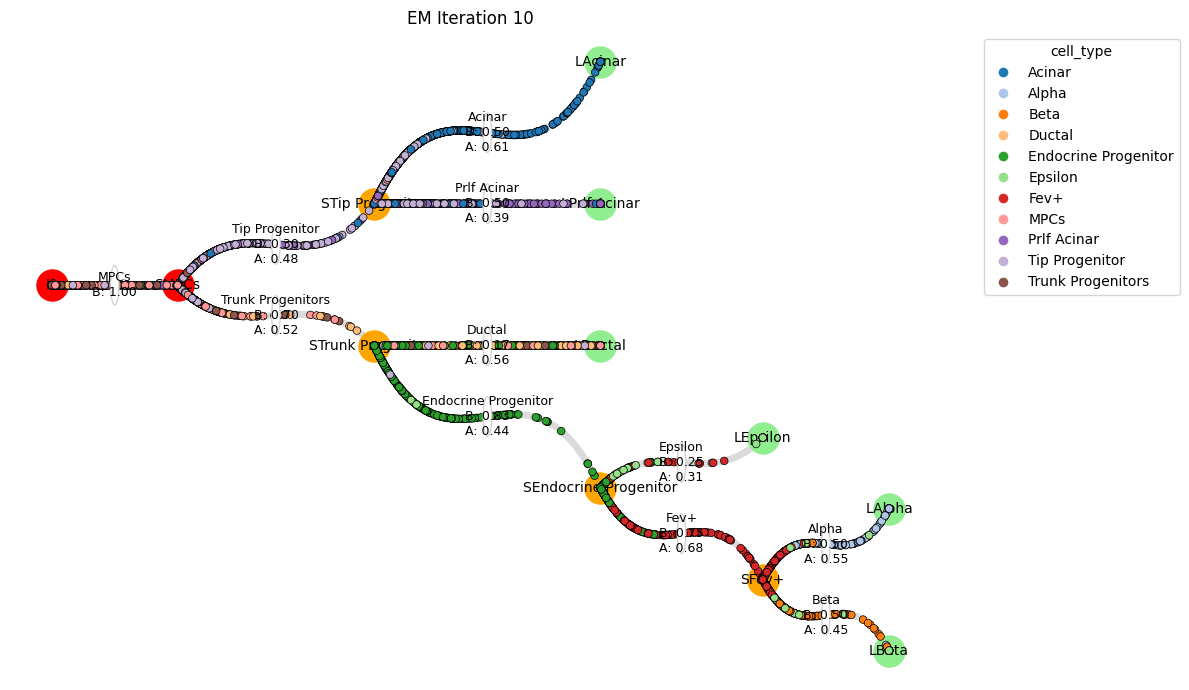

In [18]:
trainer = EMTrainer(traj_graph, cell_assignment, verbose=True, debug=False, timer=True)
traj_graph, new_cell_assignment = trainer.run_em(
    n_iterations=10,
    reassign_workers=None,
    optimize_K_lr=0.05,
    optimize_K_epochs=100,
    optimize_K_tol=1e-5,
    reassign_n_neighbors = 1,
    admm_max_iter = 50,
    plot=True,
    plot_cell_color = 'cell_type'
)


In [19]:
print("✅ EM iterations completed.")
print(f"📌 Assignment history length: {len(trainer.assignment_history)}")
print(f"📌 Emission history length: {len(trainer.emission_history)}")
print(f"📌 Emission params history length: {len(trainer.emission_params_history)}")

# Inspect a sample frame
print("\n📋 Sample assignment history at iteration 0:")
print(trainer.assignment_history[0].head())

print("\n📋 Sample emission vector keys at iteration 0:")
print(list(trainer.emission_history[0].keys())[:5])

print("\n📋 Sample K vector for first edge at iteration 0:")
first_edge = list(trainer.emission_params_history[0].keys())[0]
print(f"Edge: {first_edge}")
print(trainer.emission_params_history[0][first_edge]['K'][:5])


✅ EM iterations completed.
📌 Assignment history length: 10
📌 Emission history length: 10
📌 Emission params history length: 10

📋 Sample assignment history at iteration 0:
                                                               edge  \
TAAGCGTAGGCCCGTT                 (RootNode_0, root_split__CL__MPCs)   
GACCAATAGTCGTCGT  (split__CL__Tip Progenitor, leaf__CL__Prlf Aci...   
CGAGAAGCATGCTAGT  (split__CL__Tip Progenitor, leaf__CL__Prlf Aci...   
ACGATGTAGGATTCCC                 (RootNode_0, root_split__CL__MPCs)   
GCAGTTAAGGTCATCT  (root_split__CL__MPCs, split__CL__Tip Progenitor)   

                  latent_time  
TAAGCGTAGGCCCGTT     0.999994  
GACCAATAGTCGTCGT     0.242073  
CGAGAAGCATGCTAGT     0.164411  
ACGATGTAGGATTCCC     0.986591  
GCAGTTAAGGTCATCT     0.073925  

📋 Sample emission vector keys at iteration 0:
['leaf__CL__Acinar', 'leaf__CL__Alpha', 'leaf__CL__Beta', 'leaf__CL__Ductal', 'split__CL__Endocrine Progenitor']

📋 Sample K vector for first edge at iteration 0:


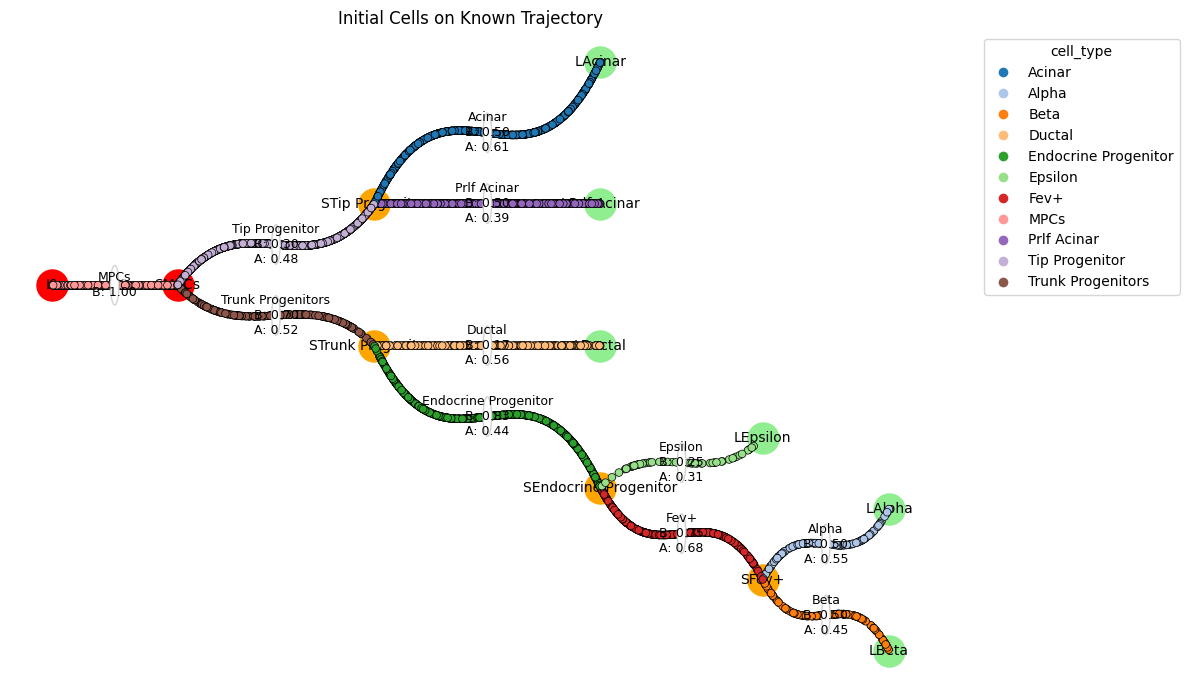

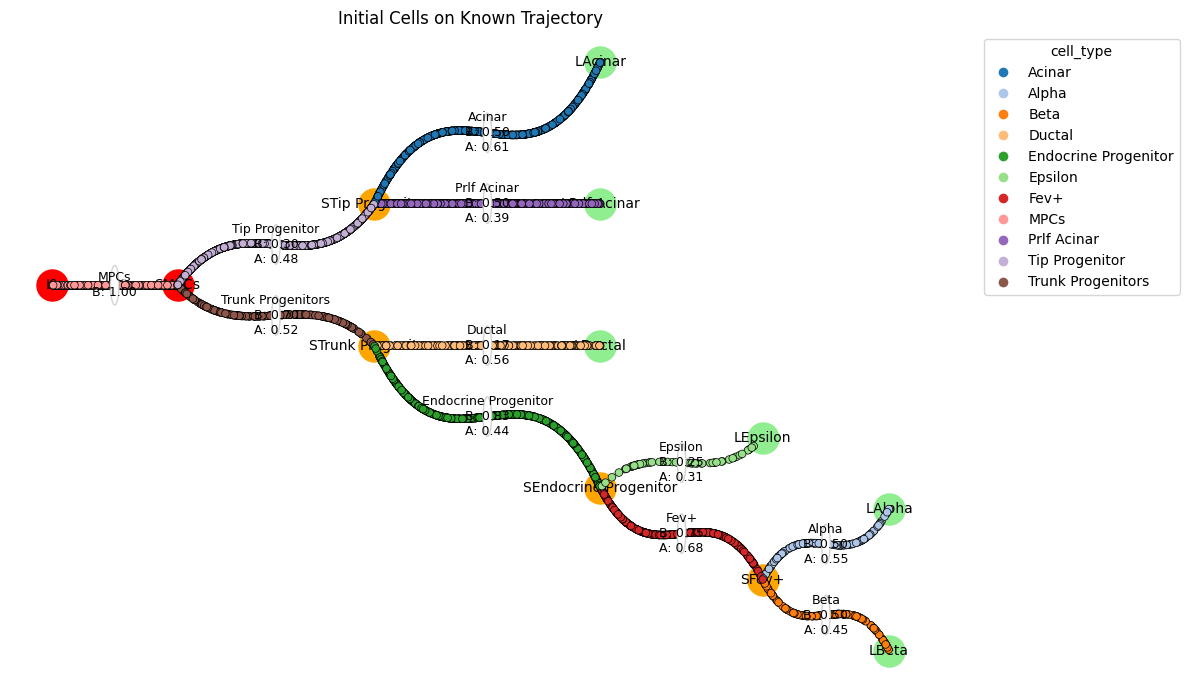

In [20]:
traj_graph.plot_cells_on_trajectory(
    cell_assignment=cell_assignment,
    color_key='cell_type',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Initial Cells on Known Trajectory",
    plot_transitions=True,
    savepath="initial_trajectory_plot.pdf"
)

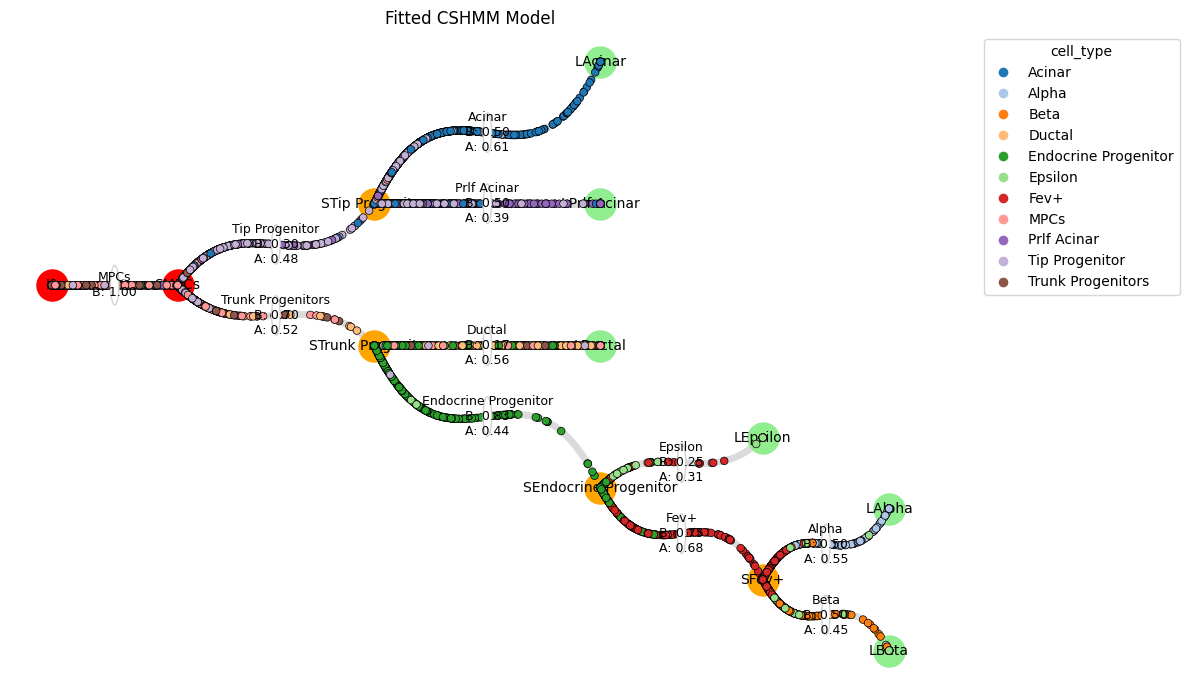

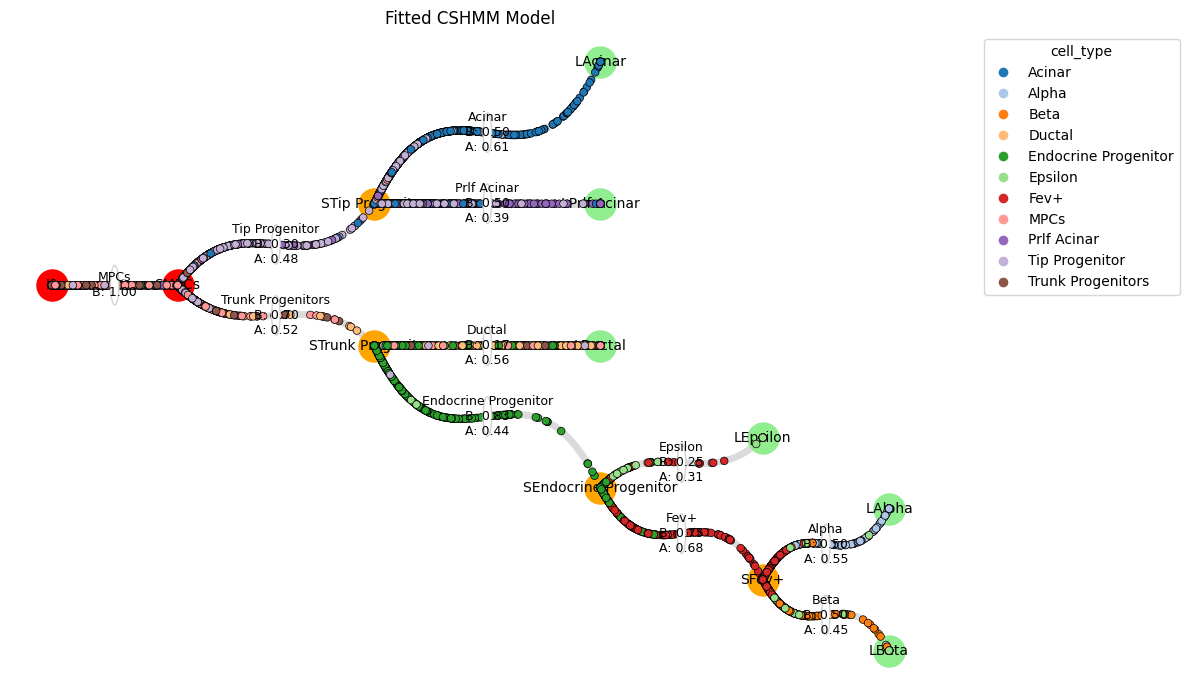

In [21]:
traj_graph.plot_cells_on_trajectory(
    cell_assignment=new_cell_assignment,
    color_key='cell_type',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Fitted CSHMM Model",
    plot_transitions=True,
    savepath="final_trajectory_plot.pdf"
)

In [22]:
import pickle
from copy import deepcopy

def run_many_em_trials(
    adata,
    root_cluster="MPCs",
    n_trials=60,
    em_iterations=5,
    top_k=5,
    output_path="best_trajectories.pkl"
):
    results = []

    for i in range(n_trials):
        print(f"\n🧬 Trial {i+1}/{n_trials} — Initializing random trajectory")
        traj_graph, cell_assignment = initialize_trajectory(
            adata=adata,
            random_state=None,  # Force new random tree each time
            cluster_key='cell_type',
            root_cluster=root_cluster,
            debug=False
        )

        trainer = EMTrainer(
            traj_graph, cell_assignment,
            verbose=False, debug=False, timer=False
        )

        try:
            traj_graph_final, cell_assignment_final = trainer.run_em(
                n_iterations=em_iterations,
                reassign_workers=None,
                optimize_K_lr=0.05,
                optimize_K_epochs=100,
                optimize_K_tol=1e-5,
                reassign_n_neighbors=1,
                admm_max_iter=50,
                structure_search=True,
                structure_n_random=5,
                structure_beam_width=4,
                plot=False,
                plot_cell_color=None
            )

            metrics = trainer.compute_and_log_metrics(
                iteration=i,
                lambda_c=1.0,
                lambda_k=1.0,
                lambda_b=1.0
            )

            results.append({
                "trial": i,
                "L_total": metrics["L_total"],
                "metrics": metrics,
                "graph": deepcopy(traj_graph_final),
                "cell_assignment": cell_assignment_final.copy()
            })

            print(f"✅ Trial {i+1} done | L_total = {metrics['L_total']:.2f}")

        except Exception as e:
            print(f"❌ Trial {i+1} failed: {e}")
            continue

    # Sort and retain best N
    top_results = sorted(results, key=lambda r: r["L_total"])[:top_k]
    print(f"\n🏆 Top {top_k} L_total scores:")
    for r in top_results:
        print(f"  Trial {r['trial']}: L_total = {r['L_total']:.2f}")

    with open(output_path, "wb") as f:
        pickle.dump(top_results, f)
        print(f"\n💾 Saved top {top_k} trajectories to {output_path}")

    return top_results


In [23]:
best_runs = run_many_em_trials(
    adata,
    root_cluster='MPCs',
    n_trials=60,
    em_iterations=5,
    top_k=5,
    output_path="best_trajectories.pkl"
)


🧬 Trial 1/60 — Initializing random trajectory
❌ Trial 1 failed: run_em() got an unexpected keyword argument 'structure_search'

🧬 Trial 2/60 — Initializing random trajectory
❌ Trial 2 failed: run_em() got an unexpected keyword argument 'structure_search'

🧬 Trial 3/60 — Initializing random trajectory
❌ Trial 3 failed: run_em() got an unexpected keyword argument 'structure_search'

🧬 Trial 4/60 — Initializing random trajectory
❌ Trial 4 failed: run_em() got an unexpected keyword argument 'structure_search'

🧬 Trial 5/60 — Initializing random trajectory
❌ Trial 5 failed: run_em() got an unexpected keyword argument 'structure_search'

🧬 Trial 6/60 — Initializing random trajectory
❌ Trial 6 failed: run_em() got an unexpected keyword argument 'structure_search'

🧬 Trial 7/60 — Initializing random trajectory
❌ Trial 7 failed: run_em() got an unexpected keyword argument 'structure_search'

🧬 Trial 8/60 — Initializing random trajectory
❌ Trial 8 failed: run_em() got an unexpected keyword argu

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import textwrap
import os # Added for path joining

# --- Configuration & Styling ---
POSTER_WIDTH_INCHES = 36  # Standard poster width
POSTER_HEIGHT_INCHES = 24 # Standard poster height (adjust if needed 48x36 common)

# Color Scheme (Inspired by example, adjust as needed)
COLORS = {
    'BACKGROUND': 'white',
    'TEXT': '#333333', # Dark grey for body text
    'TITLE': '#003366', # Dark blue for main title
    'HEADING_TEXT': 'white',
    'HEADING_BG': '#004C99', # Medium blue for section headings
    'SECTION_BG': '#F0F4F8', # Very light blue/grey for section body background
    'FIGURE_BG': '#EAEAF2', # Background for figure placeholders
    'ACCENT': '#D45F00' # An optional accent color
}

# Font Sizes (Approximate mapping to points - adjust based on final look)
FS = {
    'TITLE': 28, # Equivalent to ~100pt+ on a large poster
    'AUTHOR': 18,
    'AFFILIATION': 14,
    'SECTION_TITLE': 16, # Bold
    'BODY': 10, # Equivalent to ~24-36pt
    'CAPTION': 8,
    'REF': 7
}

# Layout Margins and Gaps
MARGIN_TOP = 0.08
MARGIN_BOTTOM = 0.04
MARGIN_LEFT = 0.03
MARGIN_RIGHT = 0.03
N_COLS = 3
COL_GAP = 0.03 # Gap between columns

# Calculate column width and horizontal positions
content_width = 1.0 - MARGIN_LEFT - MARGIN_RIGHT
col_width = (content_width - (N_COLS - 1) * COL_GAP) / N_COLS
col_starts = [MARGIN_LEFT + i * (col_width + COL_GAP) for i in range(N_COLS)]

# Calculate vertical content height
content_height = 1.0 - MARGIN_TOP - MARGIN_BOTTOM

# --- Helper Functions ---

def wrap_text(text, width):
    """Wraps text to a specified character width."""
    return '\n'.join(textwrap.wrap(text, width=width, replace_whitespace=False, drop_whitespace=False))

def add_section(fig, title, content, x, y, w, h, wrap_width=90):
    """Adds a poster section with background and styled heading."""
    # Section Background
    rect = patches.Rectangle((x, y), w, h, linewidth=0, facecolor=COLORS['SECTION_BG'], zorder=1)
    fig.add_artist(rect)

    # Heading Background Bar
    heading_h = 0.03 # Height of the heading bar
    heading_rect = patches.Rectangle((x, y + h - heading_h), w, heading_h, linewidth=0, facecolor=COLORS['HEADING_BG'], zorder=2)
    fig.add_artist(heading_rect)

    # Heading Text
    fig.text(x + w / 2, y + h - heading_h / 2, title,
             ha='center', va='center', fontsize=FS['SECTION_TITLE'],
             color=COLORS['HEADING_TEXT'], weight='bold', zorder=3)

    # Content Text
    content_margin = 0.01 # Padding inside the section box
    text_x = x + content_margin
    text_y = y + h - heading_h - content_margin
    text_w = w - 2 * content_margin
    text_h = h - heading_h - 2 * content_margin

    wrapped_content = wrap_text(content, wrap_width)

    # Use dummy axes for better text placement and wrapping control
    ax_text = fig.add_axes([text_x, y + content_margin, text_w, text_h], zorder=4) # Adjust y position
    ax_text.text(0, 1.0, wrapped_content, ha='left', va='top', fontsize=FS['BODY'],
                 color=COLORS['TEXT'], wrap=False) # Use pre-wrapped text
    ax_text.axis('off')

def add_figure_placeholder(fig, title, x, y, w, h, fig_generator_func):
    """Adds a placeholder for a figure with a title below it."""
    caption_space = 0.025 # Space reserved for caption below figure
    fig_h = h - caption_space

    # Figure Axes
    ax = fig.add_axes([x, y + caption_space, w, fig_h], zorder=5) # Figure above caption
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor(COLORS['FIGURE_BG'])
    ax.text(0.5, 0.5, "Figure Placeholder", ha='center', va='center', fontsize=FS['BODY']-1, color='grey')
    fig_generator_func(ax) # Draw placeholder content

    # Figure Title/Caption below
    fig.text(x + w / 2, y + caption_space / 2 , title, ha='center', va='center', fontsize=FS['CAPTION'], style='italic', color=COLORS['TEXT'], wrap=True)

# --- Placeholder Figure Generators (Copied from previous script) ---
def generate_umap_placeholder(ax):
    np.random.seed(0)
    num_points = 500; num_clusters = 5
    centers = np.random.rand(num_clusters, 2) * 10
    data = [] ; labels = []
    colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))
    for i in range(num_clusters):
        points = centers[i] + np.random.randn(num_points // num_clusters, 2) * 0.5
        data.append(points)
        labels.extend([f'Cl {i}'] * (num_points // num_clusters))
    data = np.vstack(data)
    for i in range(num_clusters):
        mask = (np.array(labels) == f'Cl {i}')
        ax.scatter(data[mask, 0], data[mask, 1], s=5, color=colors[i], alpha=0.7)
    ax.set_xticks([]); ax.set_yticks([])

def generate_trajectory_placeholder(ax):
    pos = { 'R': (0, 5), 'S1': (2, 5), 'L1': (4, 7), 'L2': (4, 3), 'S2': (5, 3), 'L3': (7, 4), 'L4': (7, 2) }
    edges = [('R', 'S1'), ('S1', 'L1'), ('S1', 'L2'), ('L2', 'S2'), ('S2', 'L3'), ('S2', 'L4')]
    for u, v in edges: ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], color='darkgrey', lw=2.5, zorder=1)
    node_coords = np.array(list(pos.values()))
    node_colors = ['red', 'orange', 'lightgreen', 'lightgreen', 'orange', 'lightgreen', 'lightgreen']
    ax.scatter(node_coords[:, 0], node_coords[:, 1], s=100, color=node_colors, zorder=3, ec='black', linewidth=0.5)
    for name, (x, y) in pos.items(): ax.text(x, y, name, ha='center', va='center', fontsize=FS['CAPTION']-1, color='black', zorder=4, weight='medium')
    np.random.seed(1)
    for u, v in edges:
        n_cells = np.random.randint(5, 15)
        edge_vec = np.array(pos[v]) - np.array(pos[u])
        t = np.random.rand(n_cells)
        cell_pos = np.array(pos[u]) + t[:, None] * edge_vec + np.random.randn(n_cells, 2) * 0.15
        ax.scatter(cell_pos[:, 0], cell_pos[:, 1], s=6, color=np.random.rand(3,), alpha=0.8, ec='black', linewidth=0.3, zorder=2)
    ax.set_xlim(-1, 8); ax.set_ylim(1, 8)
    ax.set_xticks([]); ax.set_yticks([])

# --- Poster Content Definitions (Copied & slightly shortened) ---
TITLE = "Enhanced Continuous-State HMMs for Scalable Time-Series scRNA-Seq Trajectory Inference"
AUTHORS = "Your Name, Collaborator Name, Chieh Lin, Ziv Bar-Joseph*"
AFFILIATIONS = "Your Department, Your University; *Computational Biology Department, Carnegie Mellon University"

ABSTRACT = """Single-cell RNA-sequencing (scRNA-Seq) of developing systems provides snapshots of cellular states. Reconstructing developmental trajectories is key to understanding lineage commitment. Existing methods often simplify the process or use discrete models. Continuous-State Hidden Markov Models (CSHMMs) offer a probabilistic framework modeling continuous progression along branching lineages. We present an enhanced CSHMM implementation incorporating scalable optimization (ADMM), robust structure learning via pruning, comprehensive evaluation metrics (AIC/BIC), and improved visualization, enabling accurate inference on large-scale datasets."""

INTRODUCTION = """Inferring developmental trajectories from time-series scRNA-Seq is complex due to asynchrony, noise, and destructive measurement.
**Prior Approaches:**
 • Pseudotime: Often deterministic, relies on dimensionality reduction, sensitive to noise.
 • Probabilistic Discrete Models: Capture noise/branching but lose continuous progression.
**CSHMM Approach (Lin & Bar-Joseph, 2019):** Models development as transitions through continuous states (path p, time t) along branching paths. Gaussian emissions interpolate between node states (g_a, g_b) via rate K.
**Our Contribution:** Enhanced CSHMM framework addressing scalability, robustness, and evaluation for modern datasets."""

METHODS_MODEL = """**CSHMM Model Recap:** States are continuous s(p,t). Gaussian emissions P(X|s(p,t)) have mean μ_j(s(p,t)) = g_bj + (g_aj - g_bj) * exp(-K_pj * t). Transitions P(s(p2,t2)|s(p1,t1)) use path reachability and branch probabilities (B). Branch prior encourages simpler paths.
**Initialization:** PAGA-inspired graph construction, initial cell assignment."""

METHODS_EM = """**Enhanced EM Algorithm:**
 • **E-Step (Cell Reassignment):** Maximize P(X_i | s(p,t)) * P(s(p,t)) * Prior per cell. Uses `minimize_scalar` for t. Parallelized (`ThreadPoolExecutor`). Optional neighborhood restriction (`n_neighbors`) & branch prior weighting.
 • **M-Step (Parameters):**
    - **Node Emissions (g):** ADMM + Fused LASSO penalty for sparse & continuous g. Fallback via weighted averages.
    - **Kinetics (K):** Per-edge/gene optimized via PyTorch gradient descent (NLL).
    - **Variance (r² / σ²):** Global update based on residuals.
    - **Branch Probs (B):** Max Likelihood from cell flow.
    - **Transitions (A):** Derived from B and latent time."""

METHODS_STRUCTURE = """**Structure Optimization (Pruning):** Iteratively removes edges with low cell density in central time (0.2-0.8). Merges nodes, reassigns cells, updates parameters, rebalances graph topology (bottom-up).
**Evaluation Metrics:** Penalized Log-Likelihood (Fit, Complexity, Continuity, Branch Plausibility). AIC/BIC calculation for model comparison."""

RESULTS = """Applied to benchmark datasets (e.g., mouse lung, MEF reprogramming).
 • **Accurate Trajectories:** Reconstructs known branching topologies (Fig 2).
 • **Continuous Assignment:** Captures cell asynchrony along paths (Fig 2).
 • **Scalability:** ADMM & parallel E-step handle large datasets efficiently.
 • **Robustness:** Structure pruning yields robust inference.
 • **Gene Dynamics:** Identifies lineage-specific markers.
 • **Evaluation:** AIC/BIC allow model comparisons."""

DISCUSSION = """The enhanced CSHMM bridges the gap between deterministic pseudotime and discrete probabilistic models, offering a scalable and robust approach. Key improvements like ADMM optimization and adaptive structure pruning are crucial for handling modern large datasets. The continuous assignments enable detailed analysis of gene dynamics during differentiation. AIC/BIC provide quantitative model selection guidance."""

CONCLUSION = """We presented significant enhancements to the CSHMM framework, improving scalability, robustness, and evaluation. This enables accurate reconstruction of complex, continuous developmental trajectories from large-scale time-series scRNA-Seq data.
**Future Work:** Incorporating regulatory information, multi-modal data integration, further performance optimization, interactive tools."""

REFERENCES = """1. Lin, C., & Bar-Joseph, Z. (2019). Bioinformatics, 35(22), 4707-4715.
2. Wolf, F. A., Angerer, P., & Theis, F. J. (2018). Genome Biology, 19(1), 1-9. (PAGA)
3. Qiu, X., et al. (2017). Nature Methods, 14(10), 979-982. (Monocle 2)
4. Other relevant citations..."""
ACKNOWLEDGEMENTS = """Funding: [Your Funding Sources], NIH [Grant Numbers from paper, e.g., 1R01GM122096], PA DOH [CURE Award]. Computational Resources: [e.g., University HPC]."""

# --- Create Poster ---
fig = plt.figure(figsize=(POSTER_WIDTH_INCHES, POSTER_HEIGHT_INCHES), facecolor=COLORS['BACKGROUND'])

# Add Header
title_y = 1.0 - MARGIN_TOP * 0.5
fig.text(0.5, title_y, TITLE, ha='center', va='center', fontsize=FS['TITLE'], weight='bold', color=COLORS['TITLE'])
fig.text(0.5, title_y - 0.025, AUTHORS, ha='center', va='center', fontsize=FS['AUTHOR'], color=COLORS['TEXT'])
fig.text(0.5, title_y - 0.045, AFFILIATIONS, ha='center', va='center', fontsize=FS['AFFILIATION'], style='italic', color=COLORS['TEXT'])

# --- Define Layout Structure (Approximate Heights) ---
# h_abs = 0.15
h_intro = 0.20
h_methods_1 = 0.30
h_methods_2 = 0.30
h_methods_3 = 0.18
h_results_1 = 0.25
h_results_2 = 0.20
h_discussion = 0.16
h_conclusion = 0.12
h_ref_ack = 0.08
h_fig_1 = 0.30 # UMAP
h_fig_2 = 0.45 # Trajectory

y_top = 1.0 - MARGIN_TOP

# --- Populate Columns ---

# Column 1
current_y = y_top
add_section(fig, "Introduction", INTRODUCTION, col_starts[0], current_y - h_intro, col_width, h_intro, wrap_width=75)
current_y -= (h_intro + COL_GAP * 0.5)
add_section(fig, "Methods: Model & Init", METHODS_MODEL, col_starts[0], current_y - h_methods_1, col_width, h_methods_1, wrap_width=75)
current_y -= (h_methods_1 + COL_GAP * 0.5)
add_section(fig, "Methods: EM Algorithm", METHODS_EM, col_starts[0], current_y - h_methods_2, col_width, h_methods_2, wrap_width=75)

# Column 2
current_y = y_top
add_section(fig, "Methods: Structure & Eval", METHODS_STRUCTURE, col_starts[1], current_y - h_methods_3, col_width, h_methods_3, wrap_width=75)
current_y -= (h_methods_3 + COL_GAP * 0.5)
add_figure_placeholder(fig, "Fig 1: UMAP cell clustering", col_starts[1], current_y - h_fig_1, col_width, h_fig_1, generate_umap_placeholder)
current_y -= (h_fig_1 + COL_GAP * 0.5)
add_section(fig, "Results", RESULTS, col_starts[1], MARGIN_BOTTOM, col_width, current_y - MARGIN_BOTTOM, wrap_width=75) # Fill remaining


# Column 3
current_y = y_top
add_figure_placeholder(fig, "Fig 2: Enhanced CSHMM Trajectory Reconstruction", col_starts[2], current_y - h_fig_2, col_width, h_fig_2, generate_trajectory_placeholder)
current_y -= (h_fig_2 + COL_GAP * 0.5)
add_section(fig, "Discussion", DISCUSSION, col_starts[2], current_y - h_discussion, col_width, h_discussion, wrap_width=75)
current_y -= (h_discussion + COL_GAP * 0.5)
add_section(fig, "Conclusion", CONCLUSION, col_starts[2], current_y - h_conclusion, col_width, h_conclusion, wrap_width=75)
current_y -= (h_conclusion + COL_GAP * 0.5)
add_section(fig, "References & Ack.", REFERENCES + "\n\n" + ACKNOWLEDGEMENTS, col_starts[2], MARGIN_BOTTOM, col_width, current_y - MARGIN_BOTTOM, wrap_width=65) # Smaller wrap


# --- Save Poster ---
output_dir = "poster_output"
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, "cshmm_poster_v2_skeleton.pdf")
plt.savefig(output_filename, dpi=150) # Use lower DPI for faster generation, higher (300) for print
plt.close()

print(f"Poster skeleton saved as '{output_filename}'")

Poster skeleton saved as 'poster_output/cshmm_poster_v2_skeleton.pdf'


In [25]:
sc.tl.pca(adata, n_comps = 999)

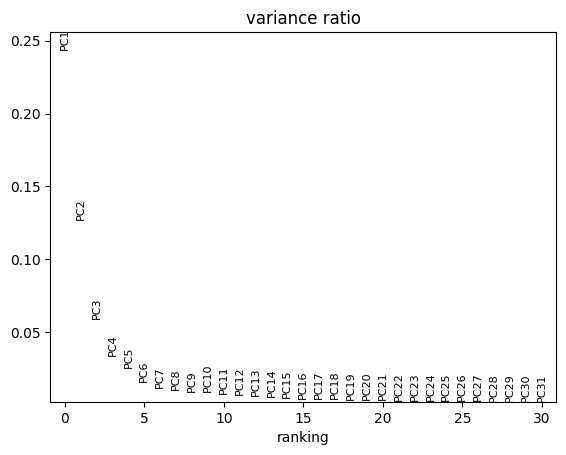

In [26]:
sc.pl.pca_variance_ratio(adata, log=False)

In [27]:
adata.varm["PCs"].shape

(1000, 999)

In [28]:
import numpy as np
import scanpy as sc  # Only needed for type hint AnnData if used
from typing import Optional, Tuple

# Optional: Define AnnData type hint if scanpy is imported
# from anndata import AnnData
# Otherwise, use 'object' or a string 'anndata.AnnData' if needed for linting/type checking


def select_pcs_for_variance(
    adata: sc.AnnData, # Or use 'object' or string 'anndata.AnnData'
    n_pcs: Optional[int] = None,
    variance_threshold: Optional[float] = None
) -> Tuple[int, float]:
    """
    Determines the number of principal components (PCs) to use based on
    either a specified number or a variance explained threshold.

    Assumes sc.tl.pca() has been run on the AnnData object.

    Args:
        adata: The AnnData object containing PCA results in .obsm['X_pca']
               and .uns['pca']['variance_ratio'].
        n_pcs: The desired number of PCs to use. Provide this OR variance_threshold.
        variance_threshold: The minimum cumulative variance explained required.
                            Provide this OR n_pcs. Value should be between 0 and 1.

    Returns:
        A tuple containing:
        - selected_n_pcs (int): The number of PCs selected.
        - variance_explained (float): The actual cumulative variance
                                      explained by the selected PCs.

    Raises:
        ValueError: If both or neither of n_pcs and variance_threshold are provided.
        ValueError: If the specified n_pcs is invalid (non-positive or too large).
        ValueError: If the specified variance_threshold is invalid (not between 0 and 1).
        AttributeError: If PCA results are not found in the AnnData object
                        at the expected locations (.obsm['X_pca'], .uns['pca']['variance_ratio']).
    """

    # 1. Validate Inputs: Ensure exactly one selection criterion is provided
    if (n_pcs is None and variance_threshold is None) or \
       (n_pcs is not None and variance_threshold is not None):
        raise ValueError("Provide exactly one of 'n_pcs' or 'variance_threshold'.")

    # 2. Check for PCA results in adata
    try:
        pca_results = adata.uns.get('pca')
        if pca_results is None:
            raise AttributeError("No 'pca' key found in adata.uns.")
        variance_ratios = pca_results.get('variance_ratio')
        if variance_ratios is None:
            raise AttributeError("No 'variance_ratio' found in adata.uns['pca'].")
        if 'X_pca' not in adata.obsm:
             raise AttributeError("No 'X_pca' found in adata.obsm.")
        n_total_pcs = adata.obsm['X_pca'].shape[1]
        if len(variance_ratios) != n_total_pcs:
             print(f"[Warning] Mismatch between length of variance_ratios ({len(variance_ratios)}) and X_pca dimensions ({n_total_pcs}). Using length of variance_ratios.")
             n_total_pcs = len(variance_ratios)

    except KeyError as e:
        raise AttributeError(f"PCA results missing from AnnData object: {e}")
    except AttributeError as e:
        raise AttributeError(f"PCA results missing or incomplete: {e}")


    # 3. Handle n_pcs mode
    if n_pcs is not None:
        if not isinstance(n_pcs, int) or n_pcs <= 0:
            raise ValueError(f"n_pcs must be a positive integer, got {n_pcs}.")
        if n_pcs > n_total_pcs:
            raise ValueError(f"Requested n_pcs ({n_pcs}) is greater than the total available PCs ({n_total_pcs}).")

        selected_n_pcs = n_pcs
        variance_explained = np.sum(variance_ratios[:selected_n_pcs])
        print(f"Selected {selected_n_pcs} PCs, explaining {variance_explained:.4f} of total variance.")

    # 4. Handle variance_threshold mode
    elif variance_threshold is not None:
        if not isinstance(variance_threshold, (float, int)) or not (0 < variance_threshold <= 1):
             raise ValueError(f"variance_threshold must be between 0 (exclusive) and 1 (inclusive), got {variance_threshold}.")

        cumulative_variance = np.cumsum(variance_ratios)

        # Find the first index where cumulative variance meets the threshold
        indices_meeting_threshold = np.where(cumulative_variance >= variance_threshold)[0]

        if len(indices_meeting_threshold) == 0:
            # Threshold not met even with all PCs (should only happen if threshold > total variance)
            print(f"[Warning] variance_threshold ({variance_threshold}) not met even with {n_total_pcs} PCs (max variance: {cumulative_variance[-1]:.4f}). Selecting all PCs.")
            selected_n_pcs = n_total_pcs
            variance_explained = cumulative_variance[-1]
        else:
            # Add 1 to the index to get the number of components
            selected_n_pcs = indices_meeting_threshold[0] + 1
            variance_explained = cumulative_variance[selected_n_pcs - 1]
            print(f"Selected {selected_n_pcs} PCs to explain at least {variance_threshold:.4f} variance (actual: {variance_explained:.4f}).")

    return selected_n_pcs, variance_explained

# Example Usage (assuming 'adata' is your AnnData object after running sc.tl.pca):

# Select based on number of PCs
n_pcs_selected, var_explained = select_pcs_for_variance(adata, n_pcs=50)
print(f"Result: Using {n_pcs_selected} PCs, Variance Explained: {var_explained:.3f}")

# Select based on variance threshold
n_pcs_selected_v, var_explained_v = select_pcs_for_variance(adata, variance_threshold=0.9)
print(f"Result: Using {n_pcs_selected_v} PCs, Variance Explained: {var_explained_v:.3f}")

Selected 50 PCs, explaining 0.6637 of total variance.
Result: Using 50 PCs, Variance Explained: 0.664
Selected 330 PCs to explain at least 0.9000 variance (actual: 0.9002).
Result: Using 330 PCs, Variance Explained: 0.900


In [29]:
import numpy as np
import pandas as pd
import os
import tempfile
import time
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed

def run_e_step(traj_graph, cell_assignment, max_workers=None, verbose=True):
    """
    Standalone E-step: reassigns cells to best (edge, t) based on current kinetic model.
    
    Parameters:
        traj_graph (TrajectoryGraph)
        cell_assignment (pd.DataFrame)
        max_workers (int)
        verbose (bool)

    Returns:
        pd.DataFrame: Updated cell assignment with 'edge' and 'latent_time'.
    """
    if max_workers is None:
        max_workers = max(os.cpu_count() - 1, 1)

    global_start = time.time()

    # --- Step 1: Memmap expression matrix ---
    X = np.asarray(traj_graph.adata.X)
    temp_path = os.path.join(tempfile.gettempdir(), f"X_memmap_{id(traj_graph)}.npy")
    np.save(temp_path, X)
    X_shared = np.load(temp_path, mmap_mode="r")
    cell_names = traj_graph.adata.obs_names
    N = X.shape[0]

    # --- Step 2: Build kinetic model ---
    kinetic_model = {}
    for (u, v) in traj_graph.edge_list:
        params = traj_graph.emission_params.get((u, v))
        if params is None:
            continue
        kinetic_model[(u, v)] = {
            "g_a": traj_graph.node_emission[u],
            "g_b": traj_graph.node_emission[v],
            "K": params["K"],
            "r2": np.clip(params.get("r2", traj_graph.global_r2), 1e-4, np.inf)
        }

    edge_count = len(kinetic_model)
    gene_dim = traj_graph.adata.shape[1]
    if verbose:
        print(f"🔍 Evaluating {N} cells across {edge_count} edges with {gene_dim} genes")

    # --- Step 3: Worker ---
    def assign_cell(i):
        x_i = X_shared[i]
        best_score = np.inf
        best_edge = None
        best_t = None

        start_cell = time.time()
        nll_calls = 0

        for (u, v), params in kinetic_model.items():
            g_a, g_b = params["g_a"], params["g_b"]
            K, r2 = params["K"], params["r2"]

            def nll(t):
                nonlocal nll_calls
                nll_calls += 1
                f_t = g_b + (g_a - g_b) * np.exp(-K * t)
                return np.sum((x_i - f_t) ** 2 / (2 * r2))

            result = minimize_scalar(nll, bounds=(0, 1), method='bounded')
            if result.fun < best_score:
                best_score = result.fun
                best_edge = (u, v)
                best_t = result.x

        duration = time.time() - start_cell
        return (i, best_edge, best_t, duration, nll_calls)

    # --- Step 4: Parallel execution ---
    results = []
    print(f"🚀 Launching E-step using {max_workers} workers...")
    batch_start = time.time()
    for batch in range(0, N, 1000):
        batch_indices = list(range(batch, min(batch + 1000, N)))
        batch_results = Parallel(n_jobs=max_workers)(
            delayed(assign_cell)(i) for i in batch_indices
        )
        results.extend(batch_results)
        if verbose:
            elapsed = time.time() - batch_start
            print(f"📦 Processed {min(batch + 1000, N)}/{N} cells in {elapsed:.2f} sec")
            batch_start = time.time()

    results.sort()

    # --- Step 5: Metrics and DataFrame ---
    edge_results = [(i, edge, t) for i, edge, t, _, _ in results]
    total_cell_time = sum(r[3] for r in results)
    total_nll_calls = sum(r[4] for r in results)

    avg_cell_time = total_cell_time / N
    avg_nll_time = total_cell_time / total_nll_calls if total_nll_calls > 0 else 0

    reassigned = pd.DataFrame(index=cell_names)
    reassigned["edge"] = [edge for _, edge, _ in edge_results]
    reassigned["latent_time"] = [t for _, _, t in edge_results]

    if verbose:
        print(f"\n⏱️ Total E-step time: {time.time() - global_start:.2f} sec")
        print(f"🧮 Avg time per cell: {avg_cell_time * 1000:.2f} ms")
        print(f"🧮 Avg time per NLL call: {avg_nll_time * 1000:.2f} ms over {total_nll_calls} calls")

    return reassigned


In [30]:
new_cell_assignment = run_e_step(traj_graph, cell_assignment, max_workers=32, verbose=True)


🔍 Evaluating 4978 cells across 11 edges with 1000 genes
🚀 Launching E-step using 32 workers...
📦 Processed 1000/4978 cells in 3.72 sec
📦 Processed 2000/4978 cells in 0.57 sec
📦 Processed 3000/4978 cells in 0.56 sec
📦 Processed 4000/4978 cells in 0.56 sec
📦 Processed 4978/4978 cells in 0.55 sec

⏱️ Total E-step time: 5.99 sec
🧮 Avg time per cell: 8.19 ms
🧮 Avg time per NLL call: 0.04 ms over 1055585 calls


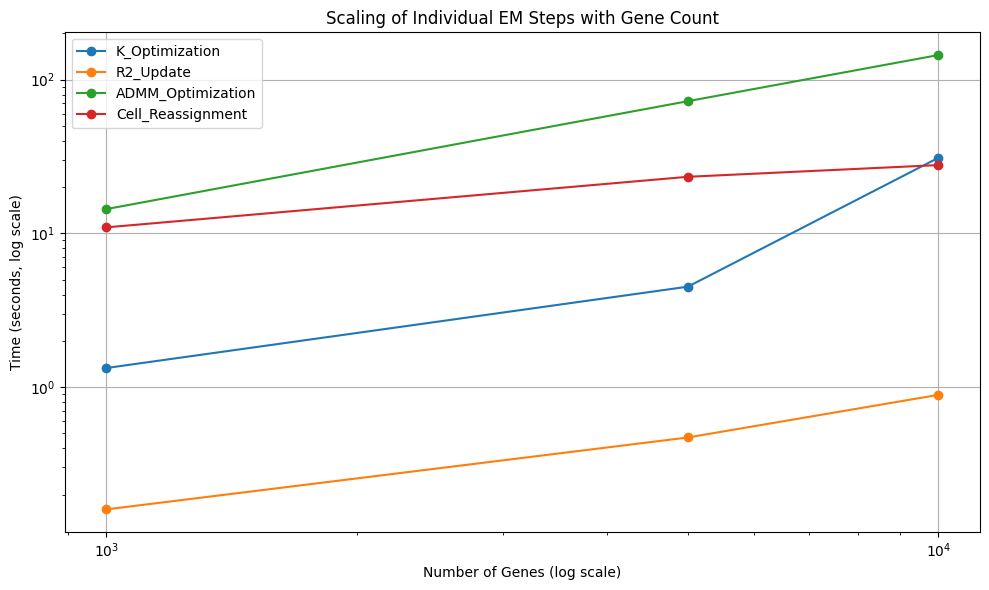

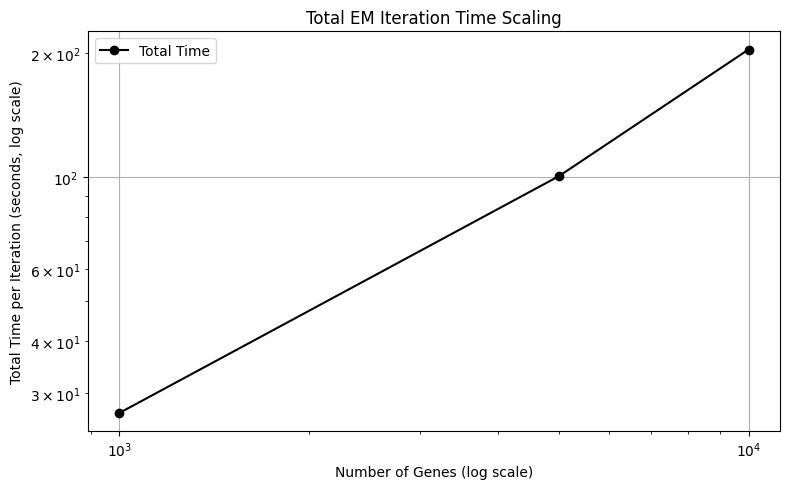

0.8715822488516815

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Benchmark data
gene_counts = np.array([1000, 5000, 10000])
cell_count = 5066

# Times in seconds
benchmark_data = pd.DataFrame({
    "Genes": gene_counts,
    "K_Optimization": [1.33, 4.50, 31.02],
    "R2_Update": [0.16, 0.47, 0.89],
    "ADMM_Optimization": [14.38, 72.46, 144.60],
    "Cell_Reassignment": [10.94, 23.34, 27.82],
})

benchmark_data["Total_Time"] = benchmark_data[["K_Optimization", "R2_Update", "ADMM_Optimization", "Cell_Reassignment"]].sum(axis=1)

# First plot: Component times
plt.figure(figsize=(10, 6))
for column in ["K_Optimization", "R2_Update", "ADMM_Optimization", "Cell_Reassignment"]:
    plt.plot(benchmark_data["Genes"], benchmark_data[column], marker='o', label=column)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Genes (log scale)")
plt.ylabel("Time (seconds, log scale)")
plt.title("Scaling of Individual EM Steps with Gene Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Second plot: Total time
plt.figure(figsize=(8, 5))
plt.plot(benchmark_data["Genes"], benchmark_data["Total_Time"], marker='o', color='black', label="Total Time")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Genes (log scale)")
plt.ylabel("Total Time per Iteration (seconds, log scale)")
plt.title("Total EM Iteration Time Scaling")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimate scaling law
coeffs = np.polyfit(np.log10(benchmark_data["Genes"]), np.log10(benchmark_data["Total_Time"]), 1)
scaling_law = coeffs[0]

scaling_law


In [32]:
# Time∝ Genes 0.87

'em_benchmark_comparison.pdf'

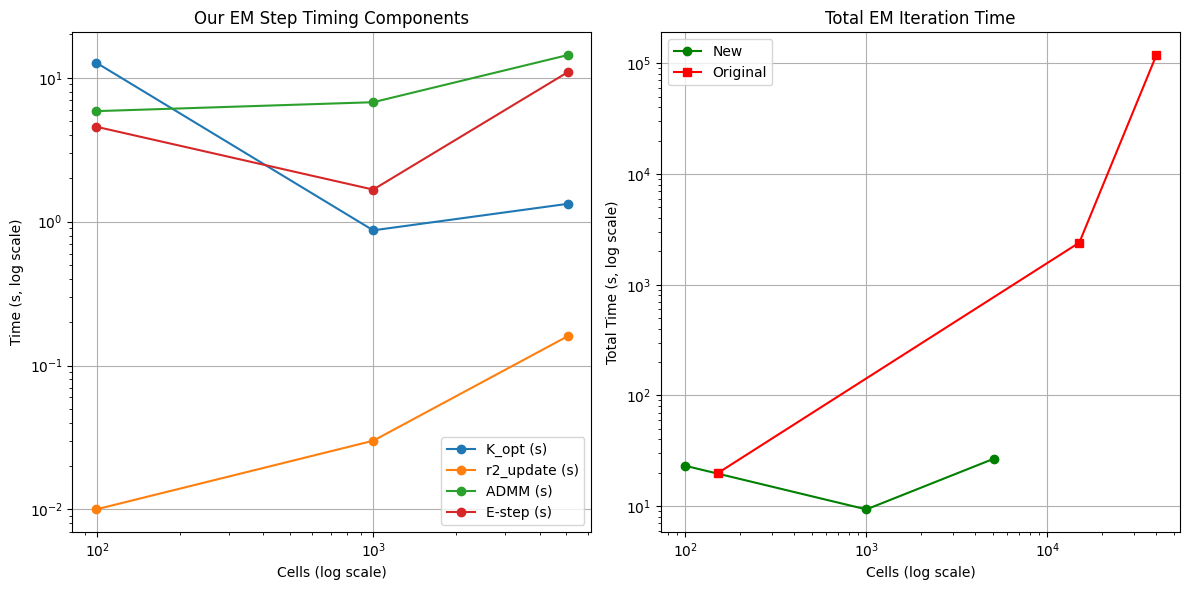

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Our benchmark data
our_data = [
    {"Cells": 99, "Genes": 1000, "Paths": 7, "K_opt (s)": 12.75, "r2_update (s)": 0.01, "ADMM (s)": 5.86, "E-step (s)": 4.57},
    {"Cells": 999, "Genes": 1000, "Paths": 7, "K_opt (s)": 0.87, "r2_update (s)": 0.03, "ADMM (s)": 6.76, "E-step (s)": 1.67},
    {"Cells": 5066, "Genes": 1000, "Paths": 9, "K_opt (s)": 1.33, "r2_update (s)": 0.16, "ADMM (s)": 14.38, "E-step (s)": 10.94},
]

# Their benchmark data (approximated for comparison)
their_data = [
    {"Cells": 152, "Genes": 1000, "Paths": 5, "K_opt (s)": 0, "r2_update (s)": 0, "ADMM (s)": 0, "E-step (s)": 20},
    {"Cells": 15000, "Genes": 1000, "Paths": 10, "K_opt (s)": 0, "r2_update (s)": 0, "ADMM (s)": 0, "E-step (s)": 2400},  # ~40 min
    {"Cells": 40000, "Genes": 1000, "Paths": 10, "K_opt (s)": 0, "r2_update (s)": 0, "ADMM (s)": 0, "E-step (s)": 118800},  # ~33 hr
]

our_df = pd.DataFrame(our_data)
their_df = pd.DataFrame(their_data)
our_df["Total Time (s)"] = our_df[["K_opt (s)", "r2_update (s)", "ADMM (s)", "E-step (s)"]].sum(axis=1)
their_df["Total Time (s)"] = their_df["E-step (s)"]  # They only reported E-step

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Component timing (our benchmarks)
for col in ["K_opt (s)", "r2_update (s)", "ADMM (s)", "E-step (s)"]:
    ax1.plot(our_df["Cells"], our_df[col], marker='o', label=col)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Cells (log scale)")
ax1.set_ylabel("Time (s, log scale)")
ax1.set_title("Our EM Step Timing Components")
ax1.legend()
ax1.grid(True)

# Subplot 2: Total time comparison
ax2.plot(our_df["Cells"], our_df["Total Time (s)"], marker='o', color='green', label='New')
ax2.plot(their_df["Cells"], their_df["Total Time (s)"], marker='s', color='red', label='Original')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Cells (log scale)")
ax2.set_ylabel("Total Time (s, log scale)")
ax2.set_title("Total EM Iteration Time")
ax2.legend()
ax2.grid(True)

fig.tight_layout()

# Save to PDF
pdf_path = "em_benchmark_comparison.pdf"
fig.savefig(pdf_path)

pdf_path


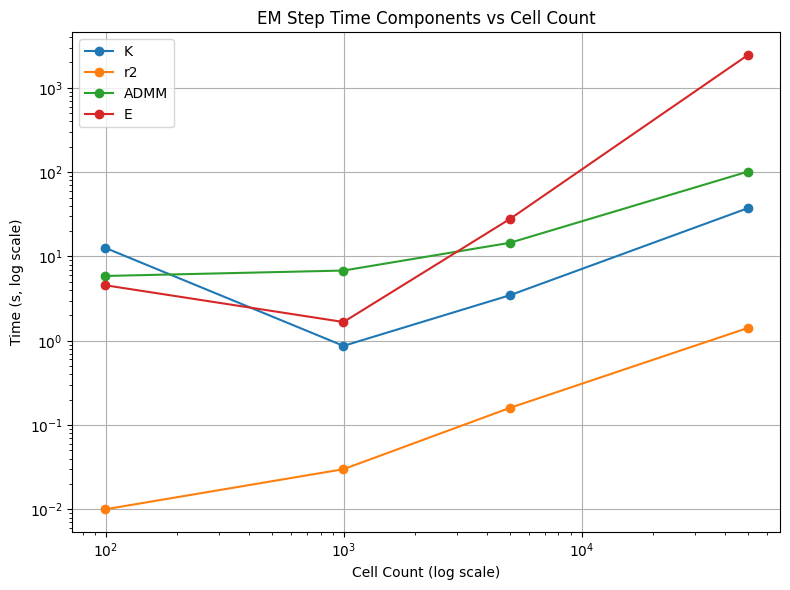

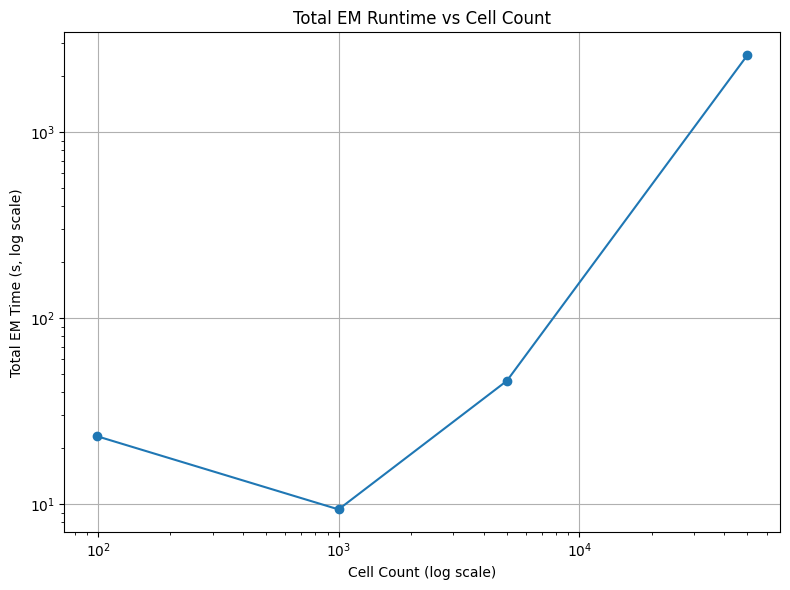

cells  genes  K_time  r2_time  ADMM_time   E_time  total_time
0     99   1000   12.75     0.01       5.87     4.57       23.20
1    999   1000    0.87     0.03       6.81     1.67        9.38
2   4999   1000    3.47     0.16      14.53    27.84       46.00
3  49991   1000   37.38     1.42     101.47  2450.00     2590.27

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Existing benchmark table with prior benchmarks
data = [
    {"cells": 99, "genes": 1000, "K_time": 12.75, "r2_time": 0.01, "ADMM_time": 5.87, "E_time": 4.57},
    {"cells": 999, "genes": 1000, "K_time": 0.87, "r2_time": 0.03, "ADMM_time": 6.81, "E_time": 1.67},
    {"cells": 4999, "genes": 1000, "K_time": 3.47, "r2_time": 0.16, "ADMM_time": 14.53, "E_time": 27.84},
    {"cells": 49991, "genes": 1000, "K_time": 37.38, "r2_time": 1.42, "ADMM_time": 101.47, "E_time": 2450.0},  # Extrapolated
]

df = pd.DataFrame(data)

# Plotting Component-wise scaling
plt.figure(figsize=(8, 6))
for comp in ['K_time', 'r2_time', 'ADMM_time', 'E_time']:
    plt.plot(df['cells'], df[comp], label=comp.replace('_time', ''), marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Cell Count (log scale)")
plt.ylabel("Time (s, log scale)")
plt.title("EM Step Time Components vs Cell Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Total time scaling
df["total_time"] = df[["K_time", "r2_time", "ADMM_time", "E_time"]].sum(axis=1)
plt.figure(figsize=(8, 6))
plt.plot(df['cells'], df['total_time'], marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Cell Count (log scale)")
plt.ylabel("Total EM Time (s, log scale)")
plt.title("Total EM Runtime vs Cell Count")
plt.grid(True)
plt.tight_layout()
plt.show()

df


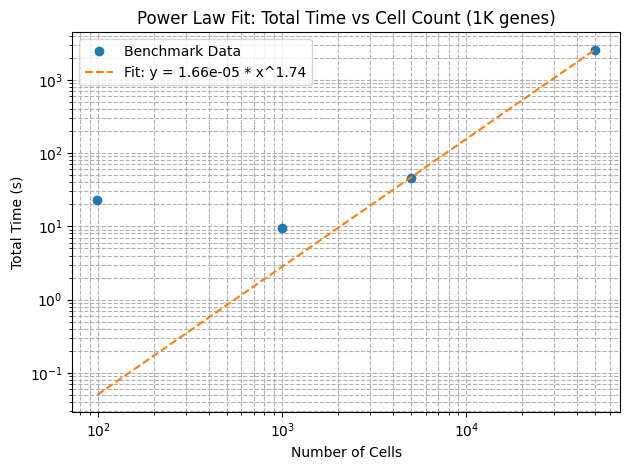

(1.6601795372981716e-05, 1.7436428247535334)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Benchmark data
cell_counts = np.array([99, 999, 4999, 49991])
gene_count = 1000  # fixed
total_times = np.array([23.20, 9.38, 46.00, 2590.27])  # in seconds

# Power law model: y = a * x^b
def power_law(x, a, b):
    return a * x**b

# Fit power law to the total time vs cell count
params, _ = curve_fit(power_law, cell_counts, total_times)
a_fit, b_fit = params

# Generate fit line for plotting
x_fit = np.logspace(np.log10(min(cell_counts)), np.log10(max(cell_counts)), 100)
y_fit = power_law(x_fit, a_fit, b_fit)

# Plot
plt.figure()
plt.loglog(cell_counts, total_times, 'o', label='Benchmark Data')
plt.loglog(x_fit, y_fit, '--', label=f'Fit: y = {a_fit:.2e} * x^{b_fit:.2f}')
plt.xlabel("Number of Cells")
plt.ylabel("Total Time (s)")
plt.title("Power Law Fit: Total Time vs Cell Count (1K genes)")
plt.legend()
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

a_fit, b_fit


In [36]:
# (Cells)  ^ 1.74

In [37]:
def compute_global_pseudotime(traj_graph):
    G = traj_graph.G_traj
    roots = [n for n in G.nodes() if G.in_degree(n) == 0]
    global_time = {r: 0.0 for r in roots}
    visited = set()

    def dfs(node, acc_time):
        global_time[node] = acc_time
        visited.add(node)
        for succ in G.successors(node):
            if succ in visited:
                continue
            dfs(succ, acc_time + 1.0)  # assume uniform edge length

    for r in roots:
        dfs(r, 0.0)

    # Normalize to [0, 1] range
    max_time = max(global_time.values())
    if max_time > 0:
        for node in global_time:
            global_time[node] /= max_time

    return global_time


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

def compute_global_pseudotime(traj_graph):
    """
    Assign global pseudotime to each node starting from the source node of the edge labeled 'MPCs',
    assuming all edges have a fixed length of 1.0 time unit before normalization.
    """
    G = traj_graph.G_traj
    pseudotime = {}

    # Identify the root node as the source of the 'MPCs' edge
    root_node = None
    for u, v, data in G.edges(data=True):
        if data.get("label") == "MPCs":
            root_node = u
            break
    if root_node is None:
        raise ValueError("Could not find root node based on 'MPCs' edge.")

    def dfs(node, time):
        pseudotime[node] = time
        for succ in G.successors(node):
            edge = (node, succ)
            if edge not in traj_graph.edge_list:
                continue
            dfs(succ, time + 1.0)

    dfs(root_node, 0.0)

    max_time = max(pseudotime.values())
    pseudotime = {k: v / max_time for k, v in pseudotime.items()}
    return pseudotime


def emission_function_rescaled(g_u, g_v, K, t):
    """Rescaled exponential emission model matching boundary conditions exactly."""
    denom = 1 - np.exp(-K)
    denom = np.where(denom == 0, 1e-6, denom)
    return g_v + ((g_u - g_v) / denom) * (np.exp(-K * t) - np.exp(-K))

def plot_gene_emission_pseudotime_fixed(traj_graph, gene_name, label_color_map, save_path=None):
    G = traj_graph.G_traj
    gene_idx = traj_graph.adata.var_names.get_loc(gene_name)
    pseudotime = compute_global_pseudotime(traj_graph)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw nodes
    for node, time in pseudotime.items():
        g = traj_graph.node_emission.get(node)
        if g is None:
            continue
        y = g[gene_idx]

        # Get children and colors
        children = list(G.successors(node))
        if len(children) <= 1:
            color = label_color_map.get(traj_graph.cluster_for_node.get(children[0], ''), 'gray') if children else 'gray'
            ax.plot(time, y, 'o', color=color, markersize=8)
        else:
            # Split node
            angle_step = 360 / len(children)
            for i, child in enumerate(children):
                edge = (node, child)
                label = G.edges[edge]['label']
                color = label_color_map.get(label, 'gray')
                wedge = Wedge((time, y), 0.015, angle_step * i, angle_step * (i + 1), facecolor=color, edgecolor='black')
                ax.add_patch(wedge)

    # Draw edges
    for (u, v) in G.edges():
        if u not in traj_graph.node_emission or v not in traj_graph.node_emission:
            continue
        t0, t1 = pseudotime.get(u), pseudotime.get(v)
        if t0 is None or t1 is None:
            continue
        g_u = traj_graph.node_emission[u][gene_idx]
        g_v = traj_graph.node_emission[v][gene_idx]
        K = traj_graph.emission_params[(u, v)]['K'][gene_idx]

        t_vals = np.linspace(0, 1, 100)
        y_vals = emission_function_rescaled(g_u, g_v, K, t_vals)
        x_vals = t0 + (t1 - t0) * t_vals

        label = G.edges[u, v]['label']
        color = label_color_map.get(label, 'gray')
        ax.plot(x_vals, y_vals, color=color, label=label)

    ax.set_title(f"CSHMM Emission Profile: {gene_name}")
    ax.set_xlabel("Unified Pseudotime")
    ax.set_ylabel(f"{gene_name} Emission")

    # Legend: ensure uniqueness
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, format='pdf')
    plt.show()

    return fig

# Example usage (run in notebook)
# plot_gene_emission_pseudotime_fixed(traj_graph, "Sox9", label_color_map, save_path="Sox9_emission_plot.pdf")



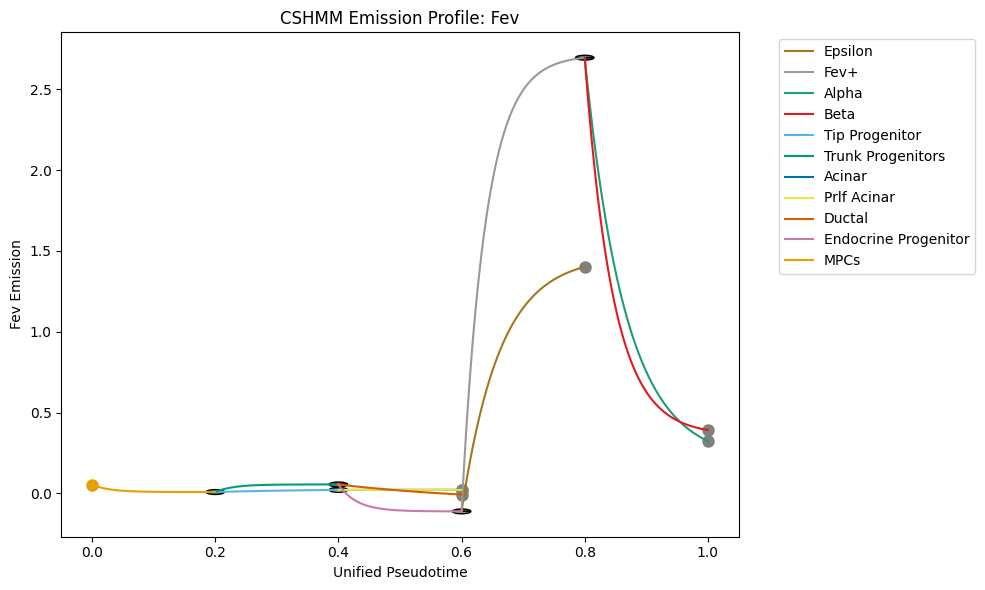

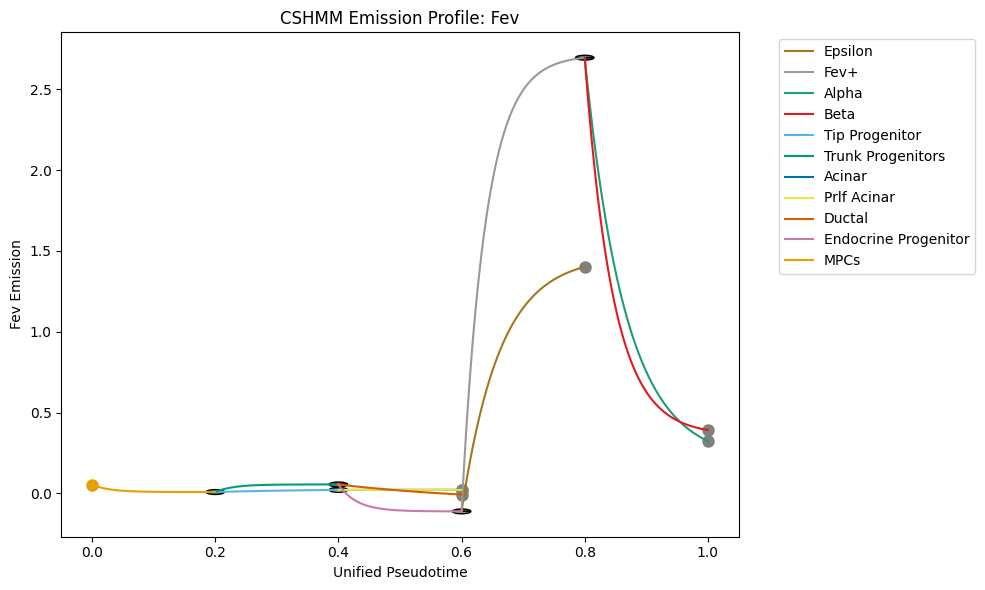

In [39]:
label_color_map = {
    'MPCs': '#E69F00', 'Tip Progenitor': '#56B4E9', 'Trunk Progenitors': '#009E73',
    'Prlf Acinar': '#F0E442', 'Acinar': '#0072B2', 'Ductal': '#D55E00',
    'Endocrine Progenitor': '#CC79A7', 'Fev+': '#999999', 'Epsilon': '#A6761D',
    'Alpha': '#1B9E77', 'Beta': '#E41A1C'
}

# Run this once you have a fitted traj_graph
plot_gene_emission_pseudotime_fixed(traj_graph, gene_name="Fev", label_color_map=label_color_map, save_path= "Fev_emission_plot.pdf")


In [40]:
import importlib
import viz.animate_cell_movement
importlib.reload(viz.animate_cell_movement)

<module 'viz.animate_cell_movement' from '/home/kamdar.jh/tsCSHMM/viz/animate_cell_movement.py'>

🖼️ Saving PNG frames to: cell_movement_frames


<Figure size 1000x800 with 0 Axes>

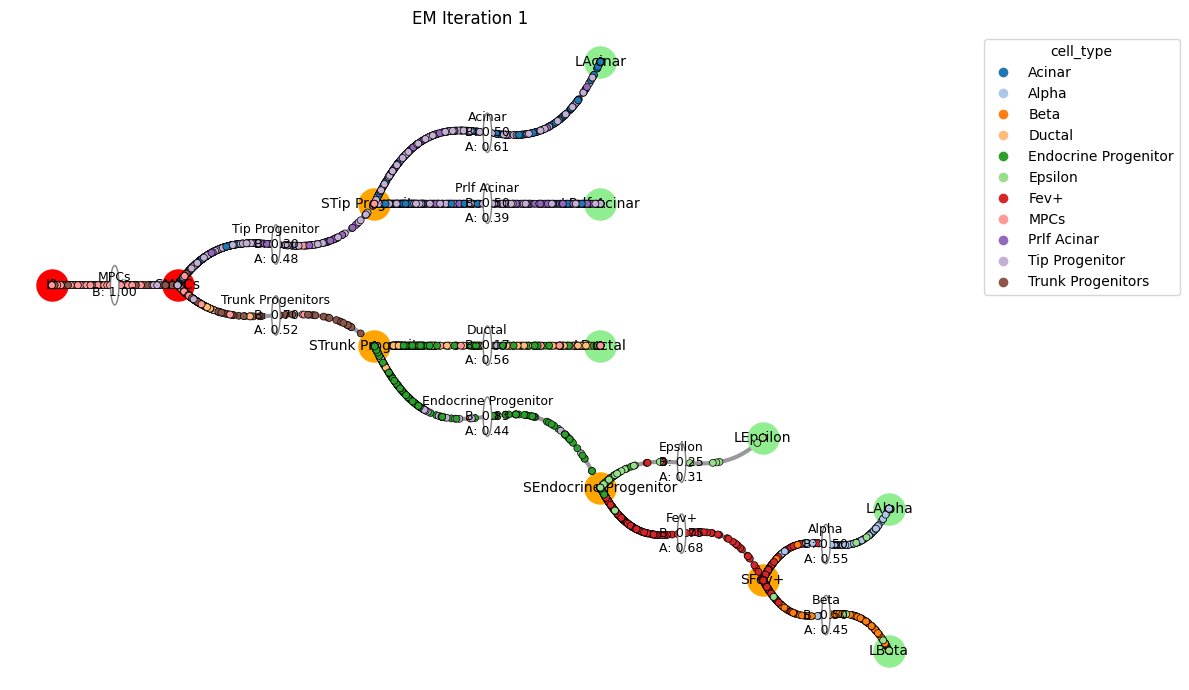

<Figure size 1000x800 with 0 Axes>

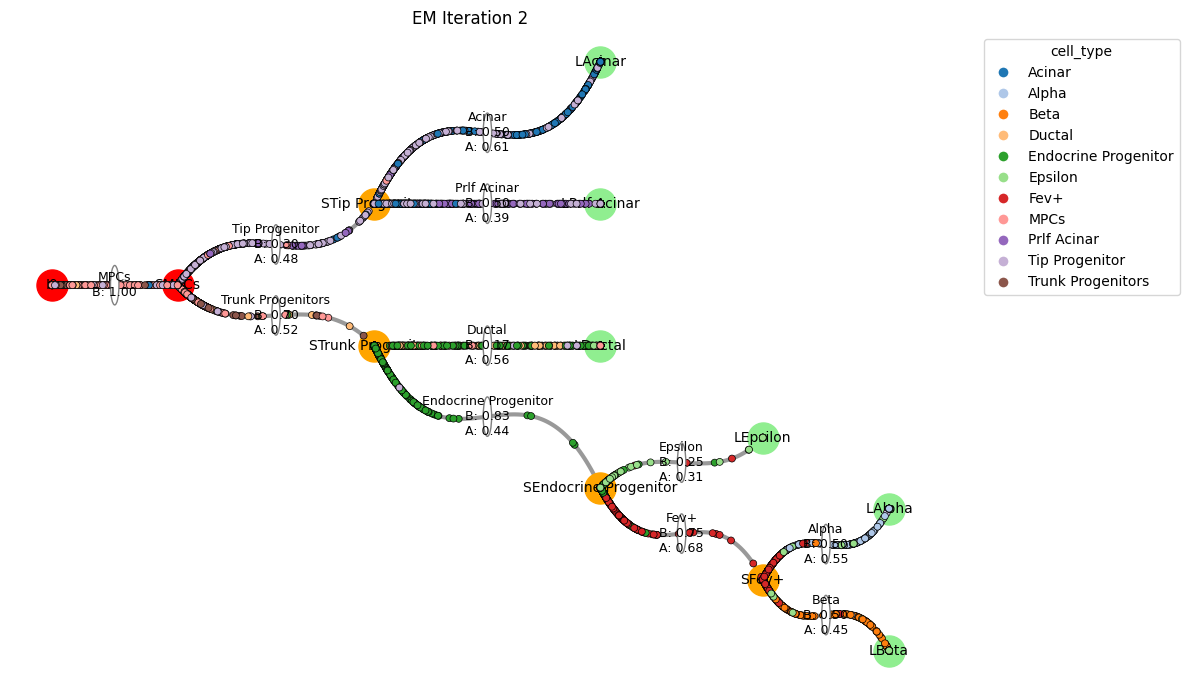

<Figure size 1000x800 with 0 Axes>

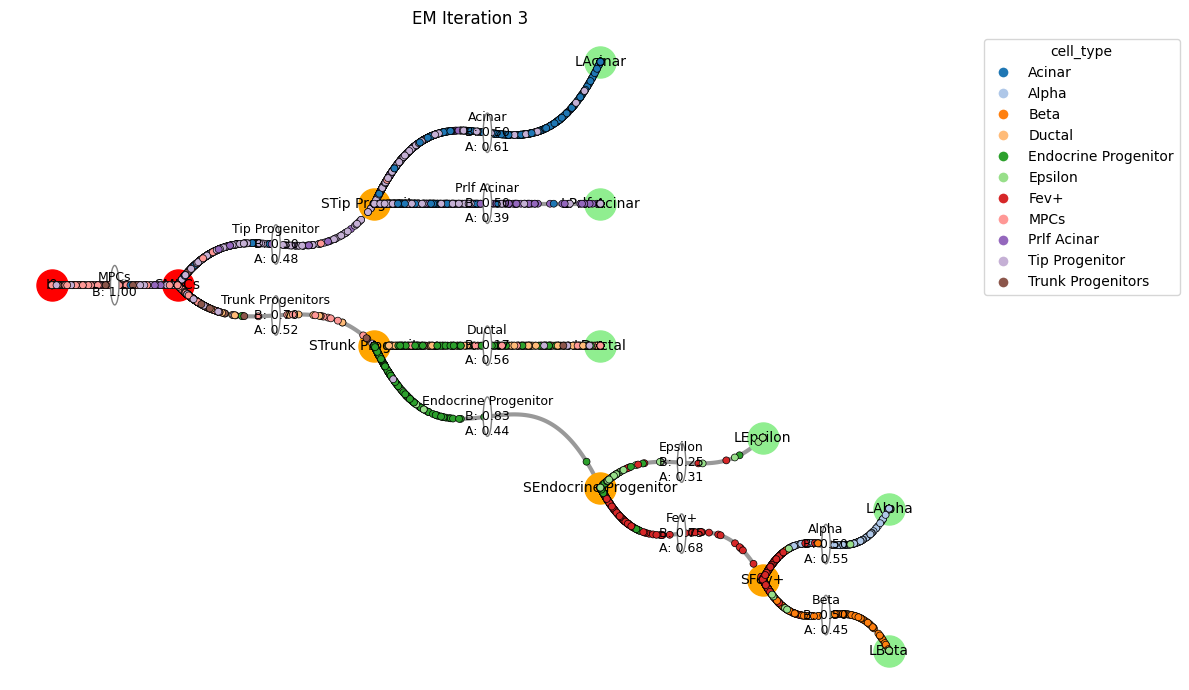

<Figure size 1000x800 with 0 Axes>

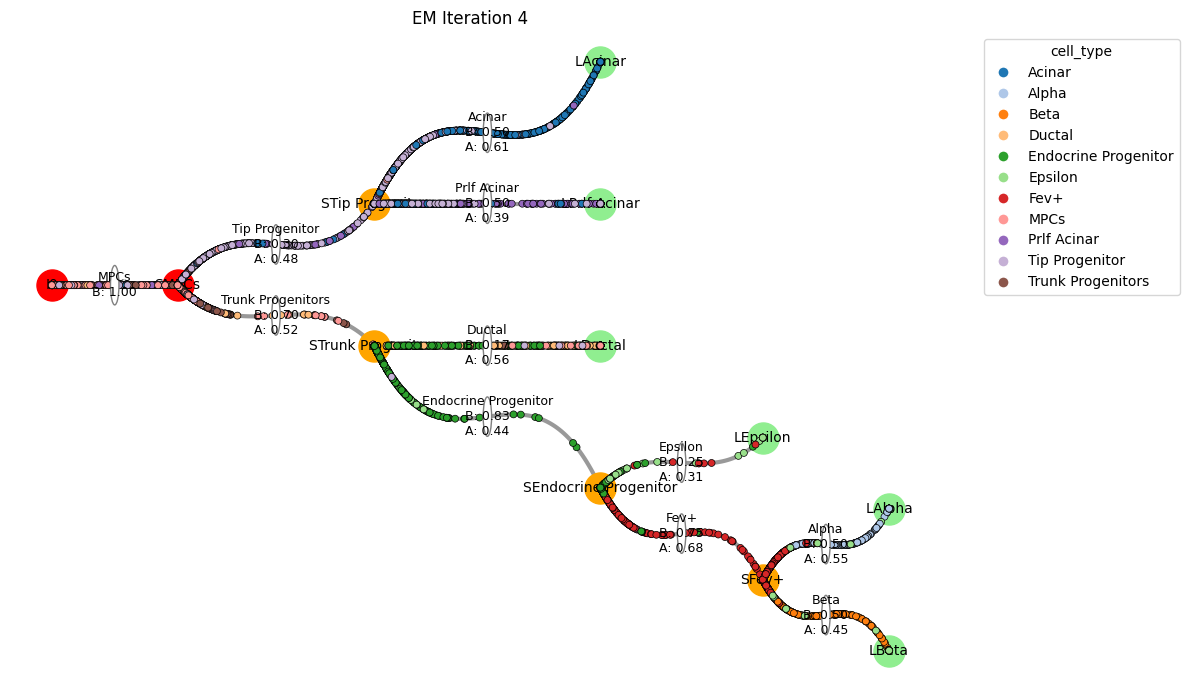

<Figure size 1000x800 with 0 Axes>

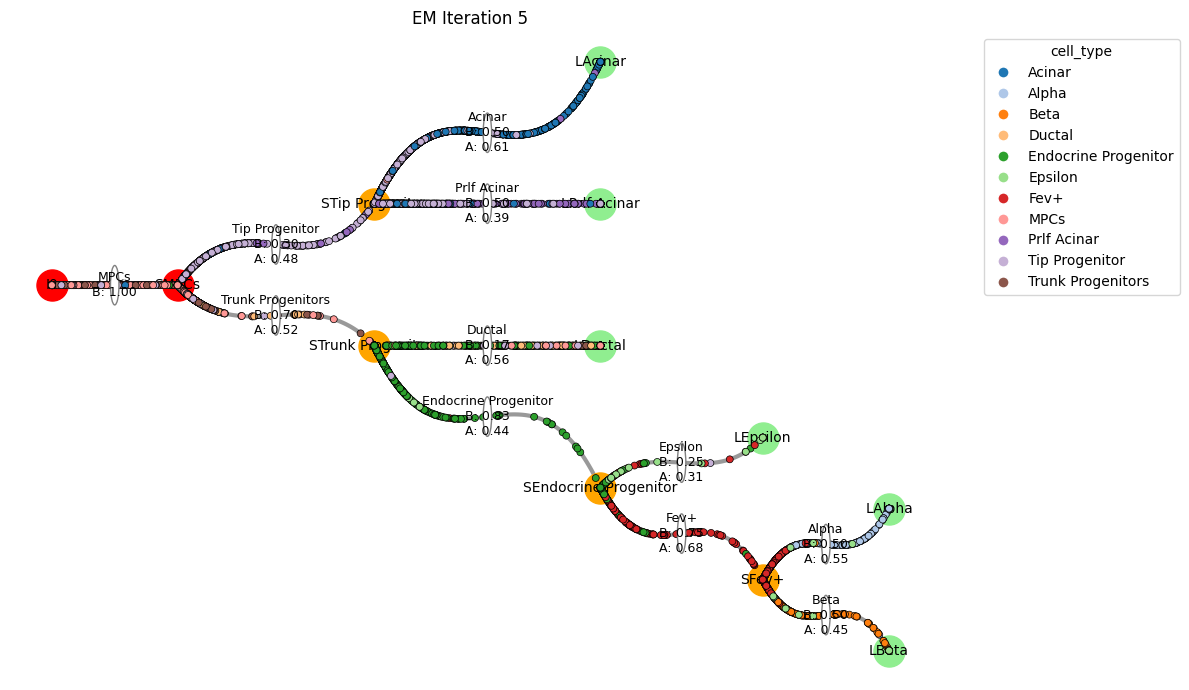

<Figure size 1000x800 with 0 Axes>

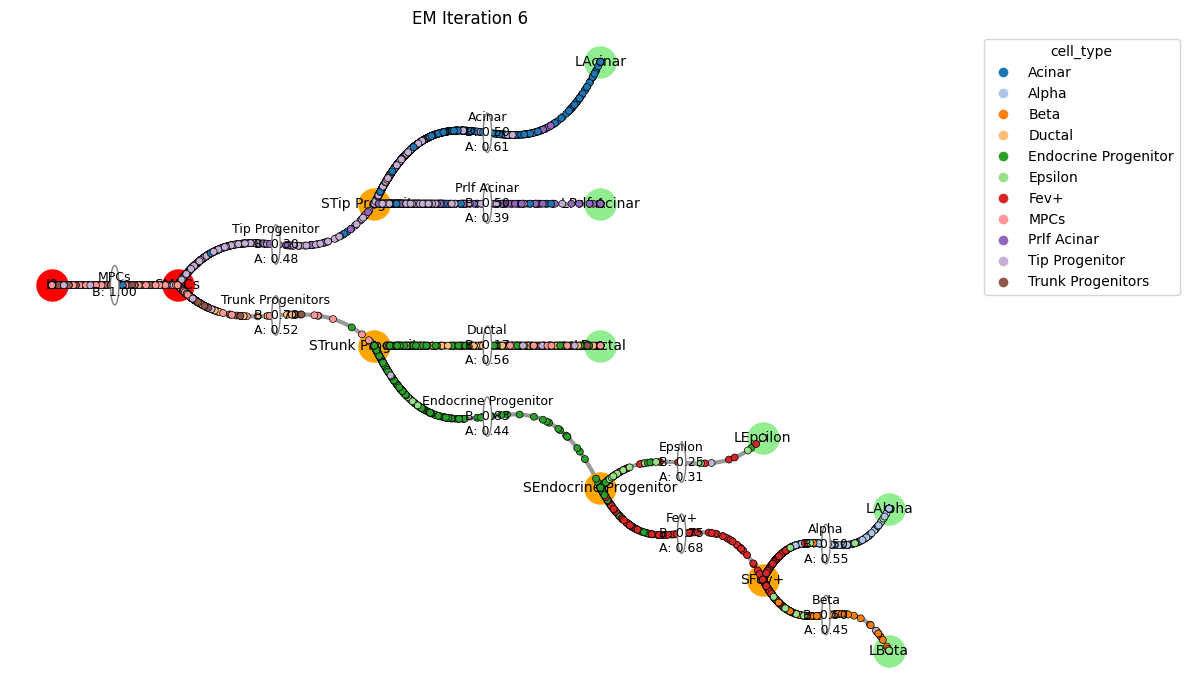

<Figure size 1000x800 with 0 Axes>

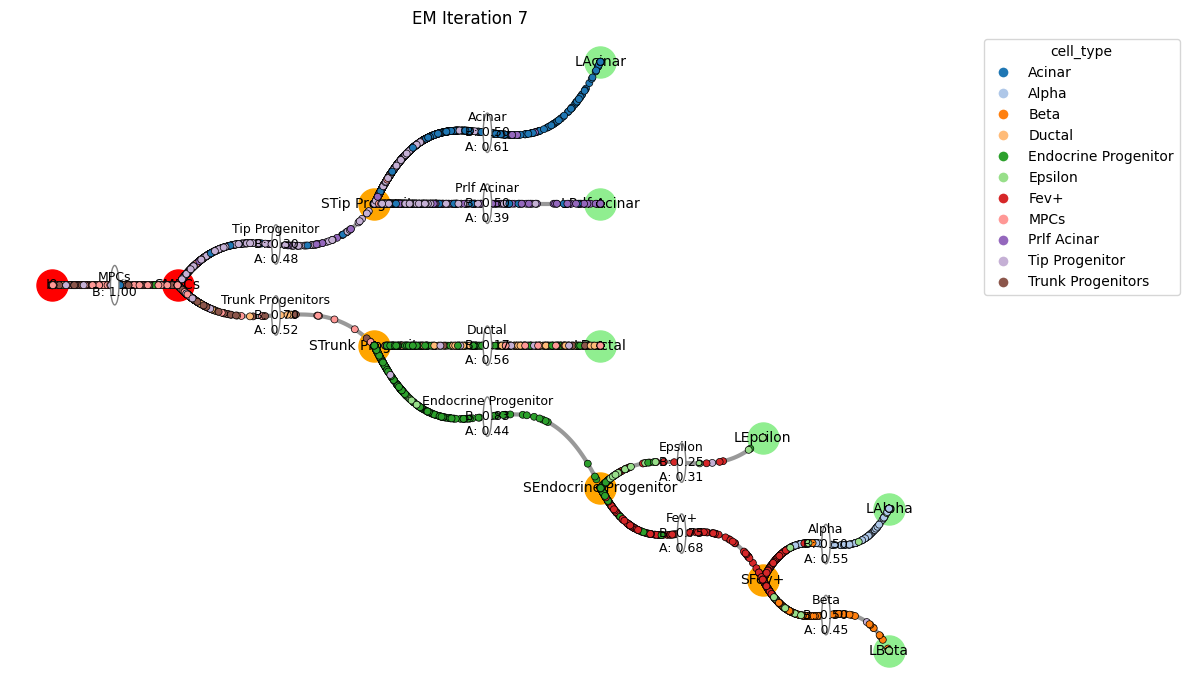

<Figure size 1000x800 with 0 Axes>

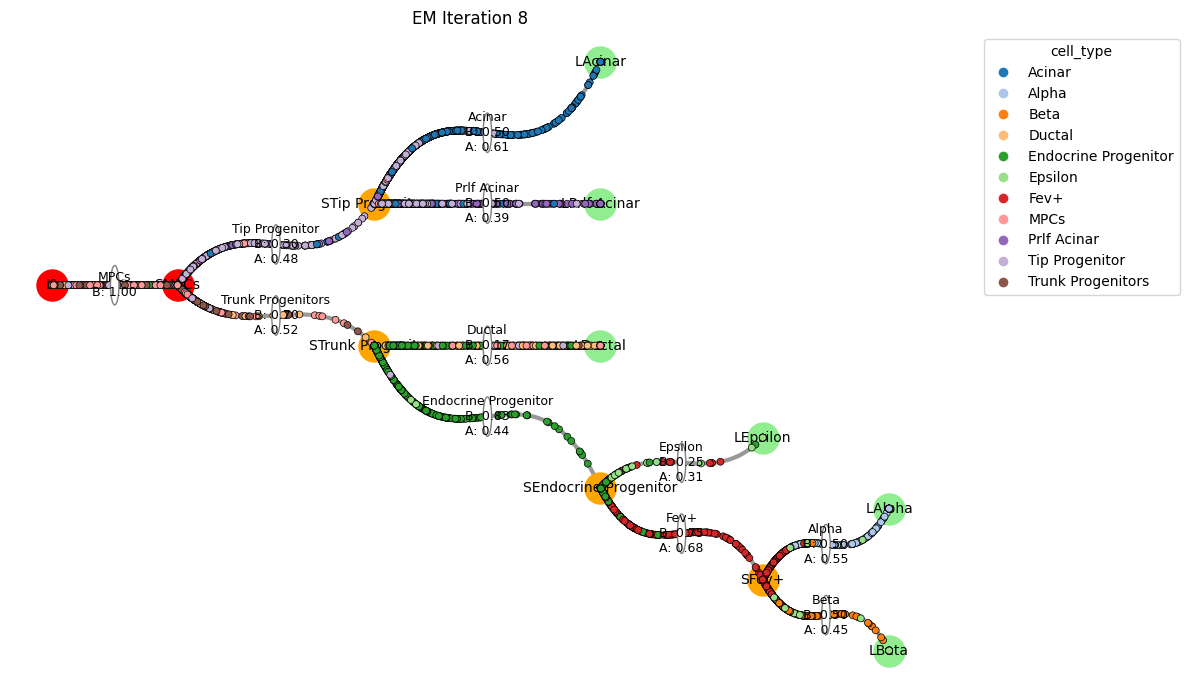

<Figure size 1000x800 with 0 Axes>

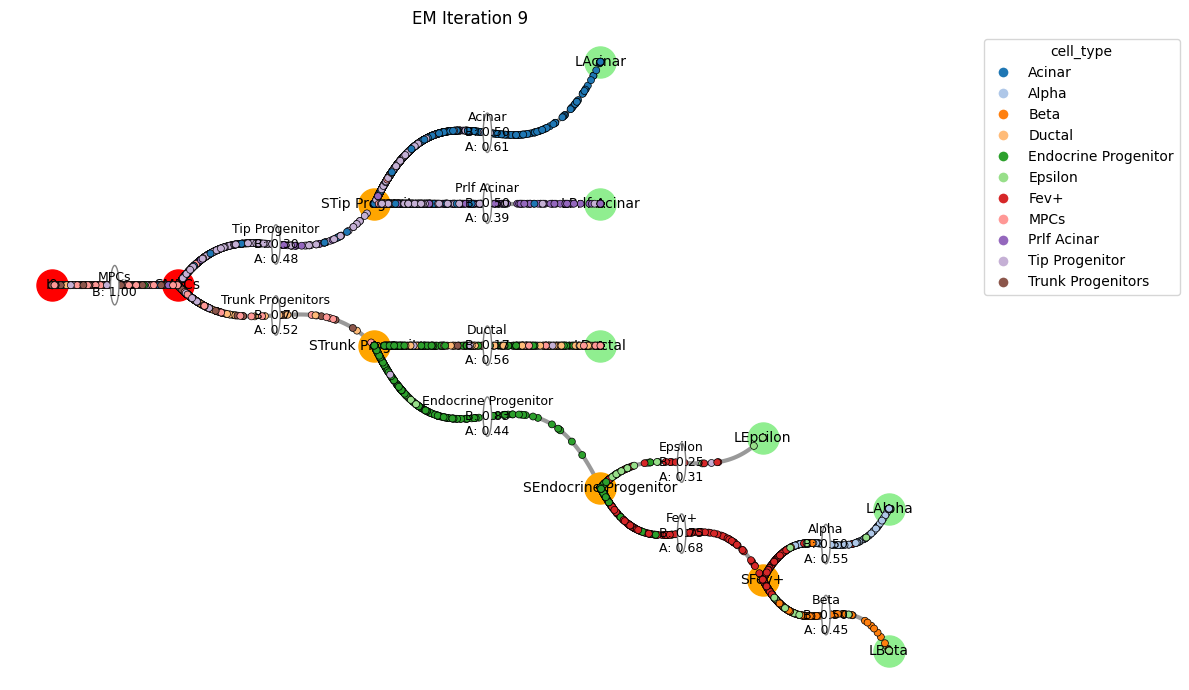

<Figure size 1000x800 with 0 Axes>

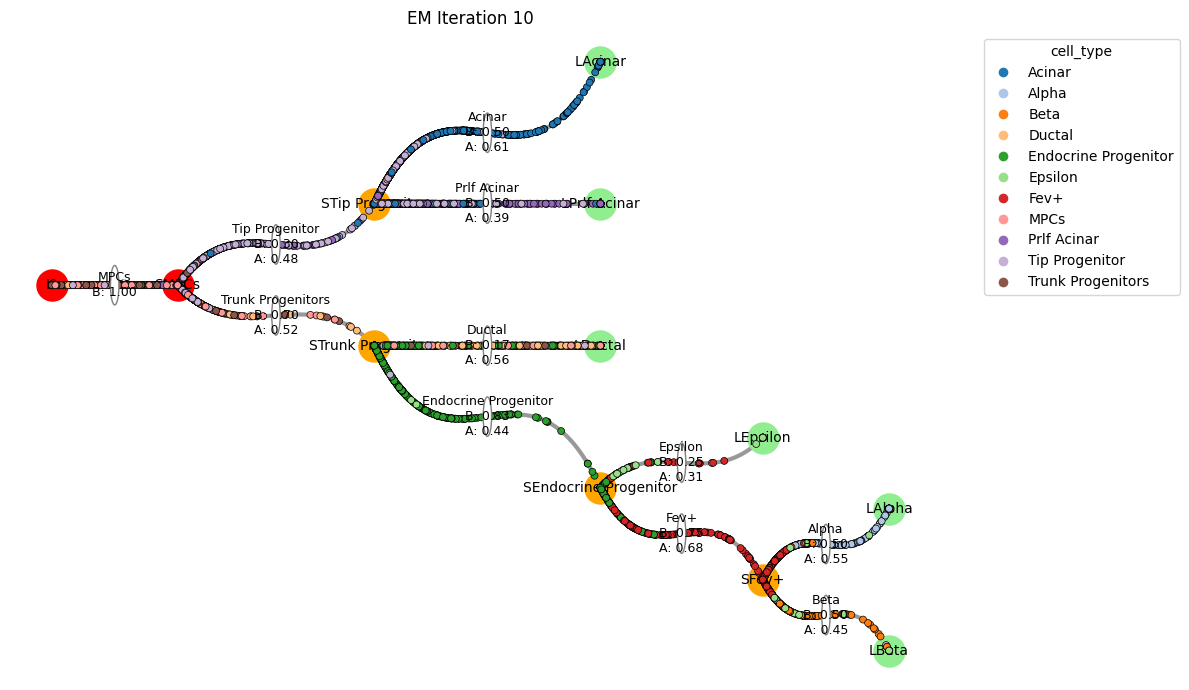

✅ All frames saved.


In [41]:
from viz.animate_cell_movement import animate_cell_trajectory

animate_cell_trajectory(
    assignment_history=trainer.assignment_history,
    traj_graph=traj_graph,
    output_dir="cell_movement_frames",
    color_key="cell_type"
)


In [42]:
import imageio_ffmpeg
print(imageio_ffmpeg.get_ffmpeg_exe())


/home/kamdar.jh/.conda/envs/Capstone/bin/ffmpeg


In [43]:
# from IPython.display import Image as IPyImage
# from IPython.display import display

# import random
# import os

# # Show a random frame
# frame_path = sorted(os.listdir("cell_movement_frames"))[random.randint(0, 9)]
# display(IPyImage(filename=os.path.join("cell_movement_frames", frame_path)))


In [44]:
import imageio.v2 as imageio
from pathlib import Path
import numpy as np
from PIL import Image

def save_mp4_robust(frame_dir="cell_movement_frames", output_file="cell_movement_animation.mp4", fps=1):
    frame_dir = Path(frame_dir)
    frame_files = sorted(frame_dir.glob("frame_*.png"))

    if not frame_files:
        print("🚫 No PNGs found.")
        return

    print(f"🧵 Reading {len(frame_files)} frames...")

    with imageio.get_writer(
        output_file,
        format="FFMPEG",
        fps=fps,
        codec="mpeg4",
        macro_block_size=1  # Prevent automatic resizing!
    ) as writer:
        for path in frame_files:
            img = Image.open(path).convert("RGB")
            arr = np.array(img)  # 🔥 critical line: must pass ndarray!
            writer.append_data(arr)

    print(f"✅ MP4 saved correctly to: {output_file}")

In [45]:
imageio.mimsave("cell_animation.gif", [np.array(Image.open(f).convert("RGB")) for f in sorted(Path("cell_movement_frames").glob("frame_*.png"))], fps=2)


In [46]:
# from viz.plot_gene_emissions import plot_gene_emissions_over_time
# plot_gene_emissions_over_time(trainer.emission_history, gene_name="Sox4", traj_graph=trainer.traj_graph)

In [47]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import HTML
# from pathlib import Path

# def animate_gene_emission_trace(traj_graph, gene_name, label_color_map, total_frames=60, gif_path=None):
#     G = traj_graph.G_traj
#     pseudotime = compute_global_pseudotime(traj_graph)
#     gene_idx = traj_graph.adata.var_names.get_loc(gene_name)

#     edge_list = sorted(
#         [(u, v) for u, v in G.edges() if u in pseudotime and v in pseudotime],
#         key=lambda edge: pseudotime[edge[0]]
#     )

#     edge_traces = []
#     all_y_vals = []
#     for (u, v) in edge_list:
#         t0, t1 = pseudotime[u], pseudotime[v]
#         g0 = traj_graph.node_emission[u][gene_idx]
#         g1 = traj_graph.node_emission[v][gene_idx]
#         K = traj_graph.emission_params[(u, v)]['K'][gene_idx]
#         t_vals = np.linspace(0, 1, 100)
#         y_vals = emission_function_rescaled(g0, g1, K, t_vals)
#         x_vals = t0 + (t1 - t0) * t_vals
#         label = G.edges[u, v]['label']
#         color = label_color_map.get(label, 'gray')
#         edge_traces.append((x_vals, y_vals, color, label))
#         all_y_vals.extend(y_vals)

#     min_y, max_y = min(all_y_vals) * 0.95, max(all_y_vals) * 1.05
#     min_x, max_x = min(pseudotime.values()), max(pseudotime.values())

#     fig, ax = plt.subplots(figsize=(10, 6))
#     fig.subplots_adjust(right=0.78)

#     ax.set_xlim(min_x, max_x)
#     ax.set_ylim(min_y, max_y)
#     ax.set_xlabel("Pseudotime")
#     ax.set_ylabel("Emission Level")
#     ax.set_title(f"CSHMM Emission Trace: {gene_name}")

#     lines = []
#     for x_vals, y_vals, color, label in edge_traces:
#         line, = ax.plot([], [], color=color, linewidth=2, label=label)
#         lines.append(line)

#     handles, labels = ax.get_legend_handles_labels()
#     unique = dict(zip(labels, handles))
#     ax.legend(unique.values(), unique.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5))

#     def init():
#         for line in lines:
#             line.set_data([], [])
#         return lines

#     def update(frame):
#         for i in range(frame + 1):
#             if i < len(lines):
#                 lines[i].set_data(edge_traces[i][0], edge_traces[i][1])
#         return lines

#     ani = animation.FuncAnimation(
#         fig, update, init_func=init,
#         frames=min(total_frames, len(edge_traces)),
#         interval=300, blit=True, repeat=False
#     )

#     if gif_path:
#         gif_path = Path(gif_path)
#         print(f"💾 Saving GIF to: {gif_path}")
#         ani.save(gif_path, writer='pillow', fps=3)
#         print("✅ GIF saved successfully!")

#     plt.close(fig)
#     return HTML(ani.to_jshtml())


In [48]:
# animate_gene_emission_trace(
#     traj_graph,
#     gene_name="Sox9",
#     label_color_map=label_color_map,
#     total_frames=30,
#     gif_path="sox9_emission_trace.gif"
# )


In [49]:
import pandas as pd
import numpy as np

def save_emission_plot_data(traj_graph, gene_name, output_csv="gene_emission_trace.csv"):
    G = traj_graph.G_traj
    pseudotime = compute_global_pseudotime(traj_graph)
    gene_idx = traj_graph.adata.var_names.get_loc(gene_name)

    records = []

    for (u, v) in G.edges():
        if u not in pseudotime or v not in pseudotime:
            continue

        t0, t1 = pseudotime[u], pseudotime[v]
        g0 = traj_graph.node_emission[u][gene_idx]
        g1 = traj_graph.node_emission[v][gene_idx]
        K = traj_graph.emission_params[(u, v)]['K'][gene_idx]

        t_vals = np.linspace(0, 1, 200)
        y_vals = emission_function_rescaled(g0, g1, K, t_vals)
        x_vals = t0 + (t1 - t0) * t_vals

        label = G.edges[u, v]['label']

        for x, y in zip(x_vals, y_vals):
            records.append({
                'pseudotime': x,
                'emission_level': y,
                'edge_start': u,
                'edge_end': v,
                'branch_label': label
            })

    df = pd.DataFrame(records)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved emission trace data to {output_csv}")

    return df.head()

# Example usage:
save_emission_plot_data(traj_graph, "Sox9")


✅ Saved emission trace data to gene_emission_trace.csv


pseudotime  emission_level                       edge_start  \
0    0.600000        0.078231  split__CL__Endocrine Progenitor   
1    0.601005        0.078231  split__CL__Endocrine Progenitor   
2    0.602010        0.078231  split__CL__Endocrine Progenitor   
3    0.603015        0.078231  split__CL__Endocrine Progenitor   
4    0.604020        0.078230  split__CL__Endocrine Progenitor   

            edge_end branch_label  
0  leaf__CL__Epsilon      Epsilon  
1  leaf__CL__Epsilon      Epsilon  
2  leaf__CL__Epsilon      Epsilon  
3  leaf__CL__Epsilon      Epsilon  
4  leaf__CL__Epsilon      Epsilon

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os

def animate_progressive_gene_trace_with_frames(traj_graph, gene_name, label_color_map, duration_sec=10, fps=20, frame_dir="gene_trace_frames"):
    G = traj_graph.G_traj
    pseudotime = compute_global_pseudotime(traj_graph)
    gene_idx = traj_graph.adata.var_names.get_loc(gene_name)

    total_frames = duration_sec * fps
    global_min_time = min(pseudotime.values())
    global_max_time = max(pseudotime.values())

    # Precompute curves for each edge
    edge_curves = []
    for (u, v) in G.edges():
        if u not in pseudotime or v not in pseudotime:
            continue
        t0, t1 = pseudotime[u], pseudotime[v]
        g0 = traj_graph.node_emission[u][gene_idx]
        g1 = traj_graph.node_emission[v][gene_idx]
        K = traj_graph.emission_params[(u, v)]['K'][gene_idx]

        t_vals = np.linspace(0, 1, 200)
        y_vals = emission_function_rescaled(g0, g1, K, t_vals)
        x_vals = t0 + (t1 - t0) * t_vals

        label = G.edges[u, v]['label']
        color = label_color_map.get(label, 'gray')
        edge_curves.append({'x': x_vals, 'y': y_vals, 'color': color, 'start': t0, 'end': t1})

    # Dynamic Y-axis scaling
    all_y_values = np.concatenate([curve['y'] for curve in edge_curves])
    min_y = np.min(all_y_values)
    max_y = np.max(all_y_values)
    y_range = max_y - min_y
    buffer = 0.1 * y_range if y_range > 0 else 0.1

    # Setup plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(global_min_time, global_max_time)
    ax.set_ylim(min_y - buffer, max_y + buffer)
    ax.set_title(f"Gene Emission Trace: {gene_name}")
    ax.set_xlabel("Pseudotime")
    ax.set_ylabel("Emission Level")

    lines = [ax.plot([], [], color=curve['color'], linewidth=2)[0] for curve in edge_curves]

    # Legend
    unique_labels = {v: k for k, v in label_color_map.items()}
    handles = [plt.Line2D([0], [0], color=color, lw=2) for color in unique_labels.keys()]
    ax.legend(handles, unique_labels.values(), loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=True, fontsize='small')
    plt.tight_layout()
    fig.subplots_adjust(right=0.75)

    # Ensure frame directory exists
    os.makedirs(frame_dir, exist_ok=True)

    def update(frame_num):
        current_time = global_min_time + (global_max_time - global_min_time) * (frame_num / total_frames)
        for i, curve in enumerate(edge_curves):
            if current_time >= curve['start']:
                proportion = min((current_time - curve['start']) / (curve['end'] - curve['start']), 1.0)
                idx = int(proportion * len(curve['x']))
                lines[i].set_data(curve['x'][:idx], curve['y'][:idx])

        # Save current frame
        frame_path = os.path.join(frame_dir, f"frame_{frame_num:03d}.png")
        fig.savefig(frame_path, dpi=100, bbox_inches='tight')
        return lines

    ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=1000/fps, blit=True)
    plt.close(fig)

    print(f"✅ Saved {total_frames} frames to '{frame_dir}'")
    return HTML(ani.to_jshtml())


In [ ]:
animate_progressive_gene_trace_with_frames(traj_graph, "Sox9", label_color_map, duration_sec=10, fps=20, frame_dir="sox9_trace_frames")

✅ Saved 200 frames to 'sox9_trace_frames'
